In [2]:
from model import ModelFromDecoding
from torchsummary import summary
import torch
shape = (3, 32, 32)
def results(s):
    m = ModelFromDecoding(s, torch.device('cpu'))
    summary(m, shape)

# Oldies but Goldies Project Documentation, WT 2020/2021 Michael Staniek
***
##### Benjamin Beilharz, 4048048

***
Genetic programming/Evolution Algorithms found their attraction in Machine Learning already quite some time ago. After Google's announcement of *AutoML*, a service that learns how to learn, consisting of a few automized block which choose data, augmented it and provided several possible feature generation/extraction capabilities. The real controversy started, when people acknowledged that *neural architecture search* might be just a replacement, because machines, learned how to learn (i.e. building architectures themselves). One of the key methods that made *AutoML* work was the utilization of genetic/evolution algorithms, which are usually targeted towards optimization problems.  
<br>
In this project, I wanted to explore a genetic encoding scheme for a highly customizable architecture, the *Convolutional Neural Networks*, while applying methods of genetic algorithms to the problem.

### Defining the Genetic Programming

![[OBG] Ablauf.PNG](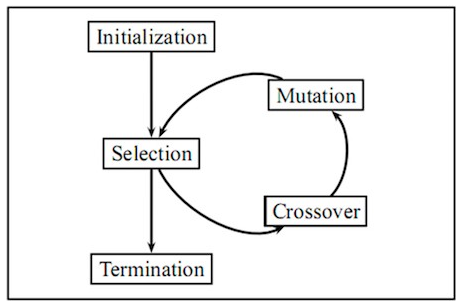)


#### Initialization

My encoding scheme is constisting of common operations seen in *CNNs*, like *Pooling* and *Convolution* layers. The structure of the blocks are closely related to the one of *ResNet*. For the choice of the respective layers we sample a variable `r` from an uniform distribution. `r` defines the layer appended to the sequence.  
In my case I defined following layers by their respective probabilities:

- if r < 0.5: Convolution block with Batch Normalization and ReLU as activation function
- if r > 0.5: Sample another variable from an uniform distribution to determine MaxPooling (s > 0.5) or MeanPooling (s < 0.5)
<br>

For the convolution layers, in channels were cached if there was a previous out channel. Out channels were sampled from positive numbers, whereas different approaches have been choosen in the experiments:
- sample from range [1,255] or,
- sample from previous human designed networks using values in [64, 128, 256, 512]
Kernel and stride size were (1, 1) and (3, 3) respectively.  
  
While for pooling layers strides and kernel sizes were both (2, 2), which made same output sizes possible.


Inputs have been padded if necessary to provide eligble dimensionalities.  
The layers have been initialized in a string sequence where:
1. Convolutions are represented as integers, and
2. Pooling layers as floats
The operations were joined by dash to differ the layers, s.t. a sample architecture looks like the following sequence:  
`128-256-0.9-0.7-512-64-0.4`; which ultimately is decoded as:
- Conv2d(cache in-channels, 128 out-channels)
- Batch Norm
- ReLU
- Conv2d(cache in-channels [128], 256 out-channels)
- Batch Norm
- ReLU
- MaxPool2d
- MeanPool2d
- Conv2d(cache in-channels [256], 512 out-channels)
- Batch Norm
- ReLU
- Conv2d(cache in-channels [512], 64 out-channels)
- Batch Norm
- ReLU
- MeanPool2d

To make a prediction onto the target (CIFAR10 was used as a dataset here), I have added a linear layer to project on the 10 target labels. The sequence length modeled is considered a hyperparameter in this case. Generation settings are defined in `ga.py`.

#### Fitness
A *fitness function* represents the objective in genetic programming. In my case it was simply the accuracy on the training set.  
After **initializing** the initial population is decoded as an architecture which was trained and returned its highest accuracy achieved during training.  
See an example architecture here (also found in `model.py`):

In [2]:
results('128-256-0.9-0.7-512-64-0.4')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 34, 34]             448
       BatchNorm2d-2           [-1, 16, 34, 34]              32
              ReLU-3           [-1, 16, 34, 34]               0
       SkipConnect-4           [-1, 16, 34, 34]               0
            Conv2d-5          [-1, 128, 36, 36]          18,560
       BatchNorm2d-6          [-1, 128, 36, 36]             256
              ReLU-7          [-1, 128, 36, 36]               0
       SkipConnect-8          [-1, 128, 36, 36]               0
            Conv2d-9          [-1, 256, 38, 38]         295,168
      BatchNorm2d-10          [-1, 256, 38, 38]             512
             ReLU-11          [-1, 256, 38, 38]               0
      SkipConnect-12          [-1, 256, 38, 38]               0
        MaxPool2d-13          [-1, 256, 20, 20]               0
        MaxPool2d-14          [-1, 256,

#### Crossover

A crucial part of genetic programming is reproducing offsprings which will optimistically perform as well/better results than their parents. This operation is implemented via chosing a random crossover point where two sampled parents   parent 1 and parent 2 switch sequences and creating two new offsprings. Parent 1 is considered the parent with the better fitness. We create as many offsprings as individuals in the current pool.  

While creating offsprings   the generated offspring has a certain chance to *mutate*. Following mutation strategies have been introduced:
1. Remove child
2. Add a pooling layer in front
3. Add a convolution layer

Mutation operations can be found in `mutation.py`.

#### Selection
The selection process defines which individuals are strong enough to live in the next generation. This is simply a highest fitness matter. I considered the top n/2 individuals for the next while removing the weakest and sampled multiple offspings that will be included in the next generation.

***
### Experiment details

Specific hyperparameters for this result are:
- Length of sequence (= architecture size)
- Number of generations (one entire process from fitness to offspring generation   potential mutation and selection)
- Number of epochs given the current generation (with the background that we will let our pool find potential good architectures first and letting it explore them later via crossovers and higher epochs)
- number of individuals dropped from selection
- number of offsprings added
- mutation operations
- expert mode (sampling from human settings)

General hyperparameters and their settings:
- Optimizer: Adam with decaying LR
- Loss: CE, hence image classification task
- LR: 0.001
- Batch size: 64 (higher didn't fit GPU memory)
- 5 offsprings added for each generation
- fixed mutation operation (see above)



***
### Results (each last generation and logs in results folder)

#### 100 generations   sequence length 10   expert mode   2 to 10 epochs

In [4]:
{'0.2-128-0.2-0.2-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 37.5,
 '0.2-128-0.2-0.2-0.8-0.8-0.7-0.2-0.3-64-512-1.0-256-512-0.2': 29.6875,
 '0.2-128-0.2-0.9-0.3-128-64-512-512-256-512-1.0-256-512-0.2': 50.0,
 '0.2-128-0.2-0.9-0.3-64-0.7-0.5-64-64-256-64-256-512-64-256': 26.5625,
 '0.2-128-0.2-0.9-0.3-64-256-0.5-64-64-256-0.8-256-256-0.2': 50.0,
 '0.2-128-0.2-0.9-0.3-64-256-0.5-64-64-256-0.8-256-256-512-128': 37.5,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2-0.1': 37.5,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 29.6875,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-256-512-0.8-256-256-0.2': 26.5625,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-256-512-0.8-256-256-512-128': 32.8125,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-64-256-64-256-512-0.2': 31.25,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-64-512-1.0-256-512-0.2-128': 29.6875,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-64-512-1.0-256-512-0.2-256-0.1': 29.6875,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-64-512-1.0-256-512-64-256-0.1': 26.5625,
 '0.2-128-0.2-0.9-0.3-64-512-512-512-256-128-0.7-256-512-0.2': 37.5,
 '0.2-128-0.2-0.9-0.3-64-512-512-512-256-512-1.0-256-512-0.2': 37.5,
 '0.2-128-0.2-0.9-0.8-0.8-0.7-0.5-0.3-64-512-1.0-256-512-0.2': 28.125,
 '0.2-128-0.2-0.9-0.8-0.8-0.7-0.5-64-256-512-0.8-256-256-512-128': 25.0,
 '0.2-128-0.2-0.9-0.8-0.8-0.7-512-256-64-128-0.7-128-512-64-256-0.1': 31.25,
 '0.2-128-0.2-0.9-256-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 25.0,
 '0.2-128-0.2-512-0.2-256-64-0.2-0.3-64-512-1.0-256-512-0.2': 37.5,
 '0.2-128-0.2-512-0.2-256-64-256-64-64-512-1.0-256-256-512-128': 26.5625,
 '0.2-128-0.2-512-0.2-256-64-256-64-64-512-1.0-256-512-0.2': 32.8125,
 '0.2-128-0.2-512-0.2-256-64-256-64-64-512-1.0-256-512-64-256-0.1': 37.5,
 '0.2-128-128-0.1-0.2-256-64-256-64-64-512-1.0-256-512-0.2': 37.5,
 '0.2-128-128-0.1-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.2-0.3-64-512-1.0-256-512-0.2': 37.5,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-0.3-64-512-1.0-256-512-64-256-0.1': 28.125,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-256-512-1.0-256-512': 28.125,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-256-512-1.0-256-512-0.2': 37.5,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-64-128-0.7-128-512-64-256-0.1': 37.5,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512': 25.0,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 37.5,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-0.2-0.1': 37.5,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-512-128': 37.5,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-64-512-0.8-256-256-0.2-0.1': 50.0,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-64-512-1.0-256-512-0.2': 28.125,
 '0.2-128-128-0.1-0.8-0.8-0.7-0.5-64-64-512-64-256-256-0.2': 37.5,
 '0.2-128-128-0.1-0.8-0.8-0.7-256-64-64-256-64-256-256-0.2': 37.5,
 '0.2-128-128-0.1-0.8-0.8-0.7-512-512-256-512-1.0-256-512-0.2': 26.5625,
 '0.2-128-128-0.1-0.8-0.8-128-512-256-64-128-0.7-256-512-0.2': 28.125,
 '0.2-128-128-0.1-0.8-0.8-128-512-512-256-512-0.8-256-256-0.2': 31.25,
 '0.2-128-128-0.1-0.8-128-128-512-512-256-512-1.0-256-512-0.2': 26.5625,
 '0.2-128-128-0.1-256-256-64-256-64-64-256-64-256-256-0.2': 26.5625,
 '0.2-128-128-0.2-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-0.3-64-512-1.0-256-512-0.2': 28.125,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-256-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-256-128-0.7-256-512-0.2': 31.25,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-256-0.8-256-256-512-128': 26.5625,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-128-512-64-256-0.1': 28.125,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512': 37.5,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 31.25,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 31.25,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-512-0.8-256-256-512-128': 28.125,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-512-0.8-256-512': 25.0,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-512-1.0-256-512-0.2': 28.125,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-512-1.0-256-512-64-256': 28.125,
 '0.2-128-128-0.2-0.7-0.8-0.7-0.5-64-64-512-64-256-512-512-128': 28.125,
 '0.2-128-128-0.2-0.7-0.8-0.7-256-64-64-512-1.0-256-512-64-256-0.1': 28.125,
 '0.2-128-128-0.2-0.7-128-0.7-0.5-64-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.2-128-128-0.2-0.7-128-0.7-0.5-64-64-256-0.8-256-256-512-128': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-0.2-0.3-256-512-0.8-256-256-0.2': 31.25,
 '0.2-128-128-0.2-0.7-128-128-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-0.5-64-64-128-0.7-128-256-0.2': 28.125,
 '0.2-128-128-0.2-0.7-128-128-0.5-64-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.2-128-128-0.2-0.7-128-128-0.5-64-64-512-1.0-256-512-0.2': 37.5,
 '0.2-128-128-0.2-0.7-128-128-0.5-64-64-512-1.0-256-512-64-256-0.1': 37.5,
 '0.2-128-128-0.2-0.7-128-128-256-512-256-512-1.0-256-512-0.2': 50.0,
 '0.2-128-128-0.2-0.7-128-128-256-64-256-128-0.7-256-512-0.2': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-256-64-64-256-64-256-256-0.2': 50.0,
 '0.2-128-128-0.2-0.7-128-128-512-0.3-64-512-1.0-128-512-64-256': 37.5,
 '0.2-128-128-0.2-0.7-128-128-512-0.3-64-512-1.0-128-512-64-256-0.1': 32.8125,
 '0.2-128-128-0.2-0.7-128-128-512-256-64-128-0.7-128-512-64-256-0.1': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-512-256-64-128-0.7-256-512-0.2': 37.5,
 '0.2-128-128-0.2-0.7-128-128-512-256-64-128-1.0-256-256-512-128': 37.5,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-128-0.7-256-256-512-128': 37.5,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-128-0.7-256-256-64-256-0.1': 28.125,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-128-0.7-256-512-0.2': 37.5,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-256-64-256-512-0.2': 28.125,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-256-64-256-512-64-256-0.1': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-0.2': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-0.2-0.1': 29.6875,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-256': 37.5,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-512': 28.125,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-512-128': 28.125,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-512-256-0.1': 25.0,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-0.2': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-64': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-64-256-0.1': 29.6875,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 28.125,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-1.0-256-512-64-256-0.1': 31.25,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-256-256-512-0.2': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-512-512-256-512-256-64-256-256': 25.0,
 '0.2-128-128-0.2-0.7-128-128-512-64-0.8-0.8-256-64-256-256': 25.0,
 '0.2-128-128-0.2-0.7-128-128-512-64-64-256-0.8-256-256-512-128': 26.5625,
 '0.2-128-128-0.2-0.7-128-128-512-64-64-256-64-256-256-64-256-0.1': 50.0,
 '0.2-128-128-0.2-0.7-128-512-0.2-0.3-0.8-128-0.7-128-512-64-256': 26.5625,
 '0.2-128-128-0.2-0.7-128-512-0.2-0.3-0.8-256-64-256-512-0.2': 31.25,
 '0.2-128-128-0.2-0.7-128-512-0.2-0.3-64-128-0.7-128-512-64-256-0.1': 26.5625,
 '0.2-128-128-0.2-0.7-128-512-0.2-0.3-64-512-1.0-256-256-512-128': 26.5625,
 '0.2-128-128-0.2-0.7-128-512-0.2-0.3-64-512-1.0-256-512-0.2': 37.5,
 '0.2-128-128-0.2-0.7-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 37.5,
 '0.2-128-128-0.2-0.7-256-256-512-256-64-128-0.8-256-512': 26.5625,
 '0.2-128-128-0.2-0.8-0.8-0.7-0.5-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.2-128-128-0.2-0.8-0.8-0.7-0.5-64-64-256-0.7-256-512-0.2': 26.5625,
 '0.2-128-128-0.2-0.8-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 28.125,
 '0.2-128-128-0.2-0.8-0.8-0.7-0.5-64-64-256-64-256-512-512-128': 26.5625,
 '0.2-128-128-0.8-0.2-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 26.5625,
 '0.2-128-128-0.8-0.2-256-64-512-512-256-256-64-256-256-0.2': 37.5,
 '0.2-128-128-0.8-0.2-256-64-512-512-256-256-64-256-256-64-256-0.1': 31.25,
 '0.2-128-128-0.8-0.2-256-64-512-512-256-256-64-256-512-64-256-0.1': 28.125,
 '0.2-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-256-512-128': 28.125,
 '0.2-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-256-64-256': 37.5,
 '0.2-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-256-64-256-0.1': 37.5,
 '0.2-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-512-0.2': 29.6875,
 '0.2-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-512-0.2-256': 28.125,
 '0.2-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-512-0.2-256-0.1': 50.0,
 '0.2-128-128-0.8-0.2-256-64-512-512-64-128-0.7-128-512-64-256-0.1': 50.0,
 '0.2-128-128-0.8-0.2-256-64-512-64-64-256-64-256-512-0.2': 31.25,
 '0.2-128-128-512-0.7-128-0.7-0.5-64-64-512-64-256-256-0.2': 37.5,
 '0.2-128-128-512-0.7-128-128-512-256-64-128-0.7-256-512-0.2': 26.5625,
 '0.2-128-128-512-0.7-128-128-512-512-256-512-0.7-128-512-64-256-0.1': 26.5625,
 '0.2-128-128-512-0.7-128-128-512-512-256-512-0.8-128-512-64-256-0.1': 28.125,
 '0.2-128-128-512-0.7-128-128-512-512-256-512-0.8-256-256-0.2': 26.5625,
 '0.2-128-128-512-0.7-128-128-512-512-256-512-0.8-256-256-512-128': 32.8125,
 '0.2-128-128-512-0.7-128-128-512-512-256-512-0.8-256-512-0.2': 26.5625,
 '0.2-128-128-512-0.7-128-128-512-512-256-512-1.0-256-256-512-128': 28.125,
 '0.2-128-128-512-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 29.6875,
 '0.2-128-128-512-0.7-128-128-512-512-256-512-256-256-512-0.2': 25.0,
 '0.2-128-128-512-0.7-128-512-0.2-0.3-0.8-256-64-256-512-0.2': 37.5,
 '0.2-128-128-512-0.7-128-512-0.2-0.3-64-512-1.0-256-512-0.2': 29.6875,
 '0.2-128-128-512-0.7-128-512-512-256-64-128-0.7-256-512-0.2': 28.125,
 '0.2-128-128-512-0.7-128-64-512-512-256-512-1.0-256-256-64-256': 26.5625,
 '0.2-128-128-512-0.7-128-64-512-512-256-512-1.0-256-512-0.2': 37.5,
 '0.2-128-128-512-256-128-0.7-512-512-256-512-1.0-256-512-0.2': 37.5,
 '0.2-128-128-512-256-128-0.7-512-512-256-512-1.0-256-512-64-256-0.1': 29.6875,
 '0.2-128-128-512-256-256-256-0.2-0.3-256-512-0.8-256-256-0.2-0.1': 26.5625,
 '0.2-128-128-512-256-256-256-512-0.3-64-512-1.0-128-512-64-256-0.1': 37.5,
 '0.2-128-128-512-256-256-256-512-256-64-128-0.7-128-512-0.2': 26.5625,
 '0.2-128-128-512-256-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 37.5,
 '0.2-128-128-512-256-256-256-512-256-64-128-0.7-256-512-0.2': 37.5,
 '0.2-128-128-512-256-256-256-512-256-64-128-0.8-256-256-0.2': 28.125,
 '0.2-128-128-512-256-256-256-512-256-64-128-0.8-256-256-512-128': 37.5,
 '0.2-128-128-512-256-256-256-512-256-64-128-0.8-256-512': 29.6875,
 '0.2-128-128-512-256-256-256-512-256-64-128-1.0-256-512-64-256-0.1': 31.25,
 '0.2-128-128-512-256-256-256-512-512-256-512-0.8-256-256-512-128': 37.5,
 '0.2-128-128-64-0.3-64-512-0.2-0.3-256-512-0.8-256-256-64-256-0.1': 28.125,
 '0.2-128-128-64-0.3-64-512-0.2-0.3-64-256-64-256-256-512-128': 26.5625,
 '0.2-128-256-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 37.5,
 '0.2-128-256-0.2-0.7-128-128-512-64-0.8-0.8-256-64-256-256': 26.5625,
 '0.2-128-256-512-256-256-256-0.5-64-64-256-0.8-256-256-512-128': 28.125,
 '0.2-128-256-512-256-256-256-0.5-64-64-256-0.8-256-256-64-256-0.1': 25.0,
 '0.2-128-256-512-256-256-256-512-256-256-512-0.8-256-256-0.2': 37.5,
 '0.2-128-256-512-256-256-256-512-256-64-128-0.7-128-256-512-128': 29.6875,
 '0.2-128-256-512-256-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.2-128-256-512-256-256-256-512-256-64-128-1.0-256-512-0.2': 26.5625,
 '0.2-128-256-512-256-256-256-512-256-64-128-64-256-256-0.2': 37.5,
 '0.2-128-256-512-256-256-256-512-512-256-512-0.8-256-512-0.2': 37.5,
 '0.2-128-256-512-256-256-256-512-512-256-512-1.0-256-256-512-128': 28.125,
 '0.2-128-256-512-256-256-256-512-512-256-512-1.0-256-512-0.2': 37.5,
 '0.2-128-256-512-256-256-64-256-64-64-256-0.8-256-256-0.2-0.1': 37.5,
 '0.2-128-256-512-256-256-64-256-64-64-256-64-256-256-0.2': 29.6875,
 '0.2-128-256-512-256-256-64-256-64-64-256-64-256-512-0.2': 26.5625,
 '0.2-128-256-512-256-256-64-256-64-64-512-1.0-256-512-0.2': 25.0,
 '0.2-128-256-512-256-64-64-256-64-64-512-1.0-256-512-64-256-0.1': 37.5,
 '0.2-256-0.2-0.9-0.3-64-512-0.2-0.3-0.8-0.8-256-256-256-0.2': 28.125,
 '0.2-256-0.2-0.9-0.3-64-512-0.2-0.3-64-512-1.0-256-512': 28.125,
 '0.2-256-0.2-0.9-0.3-64-64-256-64-64-512-1.0-256-512-64-256': 31.25,
 '0.2-256-0.2-0.9-0.3-64-64-256-64-64-512-1.0-256-512-64-256-0.1': 37.5,
 '0.2-256-0.2-0.9-0.3-64-64-256-64-64-512-64-256-512-64-256-0.1': 26.5625,
 '0.2-256-128-0.2-0.7-128-128-256-64-64-512-1.0-256-512-64-256-0.1': 26.5625,
 '0.2-256-128-0.2-0.7-128-128-512-0.3-64-512-1.0-256-512-64-256-0.1': 37.5,
 '0.2-256-128-0.2-0.7-128-128-512-256-64-128-0.7-256-512-0.2': 37.5,
 '0.2-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-0.2': 31.25,
 '0.2-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-0.2-0.1': 31.25,
 '0.2-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-512-128': 32.8125,
 '0.2-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-64-256-0.1': 37.5,
 '0.2-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512': 37.5,
 '0.2-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-0.2': 26.5625,
 '0.2-256-128-0.2-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 37.5,
 '0.2-256-128-0.2-0.7-128-128-512-512-64-512-1.0-256-512-64-256-0.1': 31.25,
 '0.2-256-128-0.2-0.7-128-512-0.2-0.3-0.8-256-64-256-512-0.2': 37.5,
 '0.2-256-128-0.2-0.7-128-64-512-512-256-512-1.0-256-512-0.2': 26.5625,
 '0.2-256-128-0.2-0.7-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 34.375,
 '0.2-256-128-512-256-256-64-256-64-256-512-1.0-256-512-0.2': 37.5,
 '0.2-256-128-512-256-256-64-256-64-64-256-64-256-256-0.2': 34.375,
 '0.2-512-128-0.1-0.7-0.8-0.7-0.5-64-64-256-64-256-512': 28.125,
 '0.2-512-128-0.1-0.7-128-128-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-0.3-256-512-0.8-256-256-0.2': 37.5,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-64-0.8-0.8-256-64-256-256': 50.0,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-64-256-512-0.8-256-256-512-128': 50.0,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-64-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-128-512-64-256-0.1': 25.0,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512': 31.25,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 37.5,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-64-256': 37.5,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 37.5,
 '0.2-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-64-256-0.2': 26.5625,
 '0.2-512-128-0.1-0.8-0.8-0.7-256-64-64-256-64-256-256-0.2': 50.0,
 '0.2-512-128-0.2-0.7-0.8-0.7-0.5-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.2-512-128-0.2-0.7-128-0.7-0.5-64-64-256-1.0-256-512-0.2': 50.0,
 '0.2-512-128-0.2-0.7-128-0.7-256-64-64-512-1.0-256-512-64-256-0.1': 28.125,
 '0.2-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-0.2': 25.0,
 '0.2-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-512-128': 25.0,
 '0.2-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-0.2': 29.6875,
 '0.2-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-512-128': 25.0,
 '0.2-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-64-256-0.1': 37.5,
 '0.2-512-128-0.9-0.3-64-512-0.2-0.3-64-512-0.8-256-256-512-128': 37.5,
 '0.2-512-128-0.9-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 37.5,
 '0.2-512-128-0.9-0.3-64-64-256-64-64-512-1.0-256-512-64-256-0.1': 50.0,
 '0.2-512-128-0.9-0.7-128-128-0.5-64-64-512-1.0-256-512-0.2': 37.5,
 '0.2-512-128-0.9-0.7-128-128-0.5-64-64-512-1.0-256-512-0.2-256-0.1': 29.6875,
 '0.2-512-128-64-0.3-64-512-0.2-0.3-0.8-256-64-256-512-0.2': 26.5625,
 '0.2-512-128-64-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 32.8125,
 '0.2-512-256-512-256-256-256-512-256-64-128-0.7-128-512-64-256': 31.25,
 '0.2-512-256-512-256-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 50.0,
 '0.2-512-256-512-256-256-256-512-256-64-128-0.7-256-512-0.2-128': 26.5625,
 '0.3-512-128-64-0.3-64-64-256-64-64-512-1.0-256-512-64-256-0.1': 28.125,
 '0.3-512-128-64-0.3-64-64-512-512-256-512-0.8-256-256-0.2-0.1': 31.25,
 '0.3-512-128-64-0.3-64-64-512-512-256-512-0.8-256-256-512-128': 37.5,
 '0.3-512-64-0.5-0.2-0.7-512-256-0.0-64-256-256-128-64-128': 26.5625,
 '0.4-128-128-0.2-0.7-0.8-0.7-0.5-64-64-512-1.0-256-512-0.2': 25.0,
 '0.4-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-256-512-128': 31.25,
 '0.4-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-512-0.2-256-0.1': 50.0,
 '0.4-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-512-512-128': 29.6875,
 '0.4-128-128-64-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 28.125,
 '0.4-128-256-512-256-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.4-128-256-512-256-256-256-512-256-64-256-64-256-256-0.2': 25.0,
 '0.4-256-128-512-256-256-64-256-64-256-512-1.0-256-512-0.2': 28.125,
 '0.4-512-0.2-0.9-0.3-64-512-0.2-0.3-0.8-0.8-256-256-512-0.2': 28.125,
 '0.4-512-128-0.1-0.3-128-512-0.2-0.3-0.8-256-64-256-512-0.2': 37.5,
 '0.4-512-128-0.1-0.3-64-0.7-0.5-64-64-128-0.7-256-512-0.2': 28.125,
 '0.4-512-128-0.1-0.3-64-0.7-0.5-64-64-256-64-256-512-0.2': 32.8125,
 '0.4-512-128-0.1-0.3-64-0.7-256-64-64-512-1.0-256-512-64-256-0.1': 26.5625,
 '0.4-512-128-0.1-0.3-64-128-512-256-64-128-0.7-128-512-64-256-0.1': 37.5,
 '0.4-512-128-0.1-0.3-64-128-512-512-256-256-64-256-512-0.2': 32.8125,
 '0.4-512-128-0.1-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 29.6875,
 '0.4-512-128-0.1-0.3-64-512-512-512-256-512-0.8-256-256-512-128': 37.5,
 '0.4-512-128-0.1-0.3-64-512-512-64-256-512-0.8-256-256-512-128': 28.125,
 '0.4-512-128-0.1-0.7-128-128-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.4-512-128-0.1-0.7-128-128-0.5-64-64-128-0.7-128-256-0.2': 37.5,
 '0.4-512-128-0.1-0.7-128-128-0.5-64-64-128-0.7-128-512-64-256-0.1': 50.0,
 '0.4-512-128-0.1-0.7-128-128-512-512-256-512-0.8-256-256-0.2': 28.125,
 '0.4-512-128-0.1-0.7-128-128-512-512-256-512-0.8-256-256-512-128': 28.125,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-0.3-64-512-1.0-256-512-0.2': 25.0,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-0.8-0.8-256-64-256-256': 26.5625,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-0.8-0.8-256-64-256-256-0.1': 37.5,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-256-128-0.7-128-512-64-256-0.1': 28.125,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-256-512-0.8-256-256-0.2': 26.5625,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-256-512-0.8-256-256-512-128': 28.125,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-128-0.7-128-512-64-256-0.1': 37.5,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-128-0.7-256-512-0.2': 26.5625,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-0.8-256-256-512-128': 28.125,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-1.0-256-512-0.2': 25.0,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-256-0.2': 37.5,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-256-512-128': 25.0,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512': 37.5,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 50.0,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-512-128': 28.125,
 '0.4-512-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 26.5625,
 '0.4-512-128-0.1-0.8-0.8-0.7-256-64-64-256-64-256-256-0.2': 37.5,
 '0.4-512-128-0.1-0.8-0.8-0.7-256-64-64-512-1.0-256-512-0.2': 50.0,
 '0.4-512-128-0.1-0.8-0.8-0.7-256-64-64-512-1.0-256-512-64-256-0.1': 29.6875,
 '0.4-512-128-0.1-0.8-0.8-512-0.2-0.3-64-512-1.0-256-512': 26.5625,
 '0.4-512-128-0.1-0.8-64-512-512-512-256-512-0.8-256-256-512-128': 26.5625,
 '0.4-512-128-0.1-0.8-64-512-512-512-256-512-1.0-256-512-0.2': 28.125,
 '0.4-512-128-0.2-0.3-64-512-0.2-0.3-64-512-1.0-256-256-0.2-0.1': 37.5,
 '0.4-512-128-0.2-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 31.25,
 '0.4-512-128-0.2-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2-256-0.1': 37.5,
 '0.4-512-128-0.2-0.3-64-512-0.2-0.3-64-512-1.0-256-512-64-256-0.1': 50.0,
 '0.4-512-128-0.2-0.7-0.8-0.7-0.5-0.3-64-512-1.0-256-512-0.2': 37.5,
 '0.4-512-128-0.2-0.7-0.8-0.7-0.5-64-256-512-0.8-256-256-512-128': 29.6875,
 '0.4-512-128-0.2-0.7-0.8-0.7-0.5-64-64-128-0.7-128-512-64-256-0.1': 31.25,
 '0.4-512-128-0.2-0.7-0.8-0.7-0.5-64-64-256-0.8-256-256-512-128': 29.6875,
 '0.4-512-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512': 29.6875,
 '0.4-512-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 28.125,
 '0.4-512-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 26.5625,
 '0.4-512-128-0.2-0.7-0.8-256-0.5-64-64-256-0.8-256-256-512-128': 32.8125,
 '0.4-512-128-0.2-0.7-0.8-256-0.5-64-64-256-64-256-512-64-256-0.1': 26.5625,
 '0.4-512-128-0.2-0.7-0.8-256-0.5-64-64-512-1.0-256-512-64-256-0.1': 37.5,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-128-0.7-128-512-64-256-0.1': 31.25,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-256-0.8-256-256-0.2': 37.5,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-256-0.8-256-256-512-128': 28.125,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-256-0.8-256-512-64-256-0.1': 26.5625,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-256-1.0-256-512-0.2': 37.5,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-256-64-256-256-0.2': 28.125,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-256-64-256-256-512-128': 37.5,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-256-64-256-256-64-256-0.1': 29.6875,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-256-64-256-512-512-128': 26.5625,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 25.0,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-512-0.8-256-256-512-128': 37.5,
 '0.4-512-128-0.2-0.7-128-0.7-0.5-64-64-512-1.0-256-512-0.2': 29.6875,
 '0.4-512-128-0.2-0.7-128-0.7-512-0.3-256-512-1.0-256-512-0.2': 50.0,
 '0.4-512-128-0.2-0.7-128-0.7-512-0.3-64-256-1.0-256-512-0.2': 28.125,
 '0.4-512-128-0.2-0.7-128-0.7-512-512-256-512-1.0-256-512-0.2': 29.6875,
 '0.4-512-128-0.2-0.7-128-0.7-512-512-256-512-1.0-256-512-0.2-0.1': 37.5,
 '0.4-512-128-0.2-0.7-128-0.7-512-512-256-512-1.0-256-512-64-256-0.1': 37.5,
 '0.4-512-128-0.2-0.7-128-128-0.2-0.3-256-512-0.8-256-256-512-128': 29.6875,
 '0.4-512-128-0.2-0.7-128-128-0.2-0.3-256-512-0.8-256-512-0.2': 32.8125,
 '0.4-512-128-0.2-0.7-128-128-0.2-0.3-64-512-1.0-256-512-0.2': 31.25,
 '0.4-512-128-0.2-0.7-128-128-0.2-0.3-64-512-1.0-256-512-64-256': 29.6875,
 '0.4-512-128-0.2-0.7-128-128-0.2-0.3-64-512-1.0-256-512-64-256-0.1': 25.0,
 '0.4-512-128-0.2-0.7-128-128-0.2-64-64-256-64-256-512': 26.5625,
 '0.4-512-128-0.2-0.7-128-128-0.5-64-64-512-1.0-256-256-0.2-0.1': 25.0,
 '0.4-512-128-0.2-0.7-128-128-0.5-64-64-512-1.0-256-512-0.2': 37.5,
 '0.4-512-128-0.2-0.7-128-128-0.5-64-64-512-1.0-256-512-64-256-0.1': 31.25,
 '0.4-512-128-0.2-0.7-128-128-256-64-256-128-0.7-256-512-0.2': 29.6875,
 '0.4-512-128-0.2-0.7-128-128-256-64-64-256-256-256-256-0.2': 50.0,
 '0.4-512-128-0.2-0.7-128-128-256-64-64-256-64-256-256-0.2': 28.125,
 '0.4-512-128-0.2-0.7-128-128-512-0.3-64-512-1.0-128-512-64-256-0.1': 37.5,
 '0.4-512-128-0.2-0.7-128-128-512-256-64-128-0.7-256-512-0.2': 28.125,
 '0.4-512-128-0.2-0.7-128-128-512-256-64-128-64-256-512-0.2': 28.125,
 '0.4-512-128-0.2-0.7-128-128-512-512-256-128-0.7-256-512-0.2': 31.25,
 '0.4-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-0.2': 31.25,
 '0.4-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-512-128': 26.5625,
 '0.4-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-64-256-0.1': 25.0,
 '0.4-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-0.2': 28.125,
 '0.4-512-128-0.2-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 25.0,
 '0.4-512-128-0.2-0.7-128-128-512-512-64-512-0.8-256-256-512-128': 28.125,
 '0.4-512-128-0.2-0.7-128-128-512-512-64-512-0.8-256-512-512-128': 25.0,
 '0.4-512-128-0.2-0.7-128-128-512-64-0.8-0.8-256-64-256-256': 28.125,
 '0.4-512-128-0.2-0.7-128-128-512-64-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.4-512-128-0.2-0.7-128-512-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.4-512-128-0.2-0.7-128-64-512-512-256-512-1.0-256-512-0.2': 50.0,
 '0.4-512-128-0.2-0.7-256-128-512-512-256-512-0.8-256-256-512-128': 37.5,
 '0.4-512-128-0.2-0.7-256-256-512-256-64-128-0.7-128-256-0.2-0.1': 31.25,
 '0.4-512-128-0.2-0.7-256-256-512-256-64-128-0.7-128-256-0.2-0.1-0.1': 37.5,
 '0.4-512-128-0.2-0.7-256-256-512-256-64-128-0.7-128-512-0.2': 37.5,
 '0.4-512-128-0.2-0.7-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.4-512-128-0.2-0.7-64-512-0.2-0.3-256-512-0.8-256-256-0.2-0.1': 26.5625,
 '0.4-512-128-0.2-256-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.4-512-128-0.8-0.2-256-64-256-64-0.8-0.8-256-64-256-256': 37.5,
 '0.4-512-128-0.8-0.2-256-64-512-512-256-512-1.0-256-512-0.2-256-0.1': 28.125,
 '0.4-512-128-0.9-0.3-64-256-0.5-64-64-256-0.8-256-256-512-128': 26.5625,
 '0.4-512-128-512-0.7-128-128-512-0.3-64-512-1.0-128-512-64-256': 26.5625,
 '0.4-512-128-512-0.7-128-128-512-512-256-128-0.7-256-512-0.2': 37.5,
 '0.4-512-128-512-0.7-128-128-512-512-256-256-64-256-512-0.2': 37.5,
 '0.4-512-128-512-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 32.8125,
 '0.4-512-128-512-256-0.8-0.7-0.5-64-64-256-64-256-512': 26.5625,
 '0.4-512-128-512-256-256-256-512-256-64-128-0.7-128-512-512-128': 50.0,
 '0.4-512-128-512-256-256-256-512-256-64-128-0.7-128-512-64-256': 25.0,
 '0.4-512-128-512-256-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 37.5,
 '0.4-512-128-512-256-256-256-512-256-64-128-0.7-256-256-0.2': 28.125,
 '0.4-512-128-512-256-256-256-512-256-64-512-0.8-256-256-512-128': 37.5,
 '0.4-512-128-512-256-256-256-512-256-64-512-64-256-512-0.2': 26.5625,
 '0.4-512-128-512-256-256-64-256-64-0.8-0.8-256-64-256-256': 29.6875,
 '0.4-512-128-512-256-256-64-256-64-0.8-512-1.0-256-512-0.2': 26.5625,
 '0.4-512-128-512-256-256-64-256-64-256-512-0.8-256-256-512-128': 25.0,
 '0.4-512-128-512-256-64-512-0.2-0.3-64-512-0.8-256-256-512-128': 26.5625,
 '0.4-512-128-64-0.3-128-128-512-512-256-512-0.8-256-256-0.2-0.1': 26.5625,
 '0.4-512-128-64-0.3-128-128-512-512-256-512-0.8-256-512': 28.125,
 '0.4-512-128-64-0.3-128-128-512-512-64-512-0.8-256-256-512-128': 28.125,
 '0.4-512-128-64-0.3-64-0.7-0.5-64-64-128-0.7-128-512-64-256-0.1': 26.5625,
 '0.4-512-128-64-0.3-64-0.7-0.5-64-64-256-64-256-512-0.2': 26.5625,
 '0.4-512-128-64-0.3-64-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 25.0,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2': 28.125,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2-0.1': 25.0,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-256-512-0.8-256-256-512-128': 25.0,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-256-512-0.8-256-256-64-256-0.1': 37.5,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-256-512-0.8-256-512-64-256-0.1': 25.0,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-256-512-1.0-256-512-0.2': 28.125,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-128-0.7-128-512-64-256-0.1': 29.6875,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-256-64-256-256-512-128': 50.0,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-256-64-256-256-64-256-0.1': 28.125,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-256-64-256-512': 26.5625,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-512-0.8-256-256-0.2': 25.0,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-512-0.8-256-256-512-128': 29.6875,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-512-1.0-128-512-64-256-0.1': 50.0,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-512-1.0-256-512': 26.5625,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 31.25,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-512-1.0-256-512-64': 26.5625,
 '0.4-512-128-64-0.3-64-512-0.2-0.3-64-512-1.0-256-512-64-256-0.1': 37.5,
 '0.4-512-128-64-0.3-64-64-256-64-64-128-0.7-128-512-0.2': 37.5,
 '0.4-512-128-64-0.3-64-64-256-64-64-128-0.7-256-512-0.2': 50.0,
 '0.4-512-128-64-0.3-64-64-256-64-64-512-1.0-256-512-512-128': 28.125,
 '0.4-512-128-64-0.3-64-64-256-64-64-512-1.0-256-512-64-256-0.1': 29.6875,
 '0.4-512-128-64-0.7-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 26.5625,
 '0.4-512-128-64-0.7-128-512-0.2-0.3-0.8-256-64-256-512-0.2': 28.125,
 '0.4-512-256-512-256-256-256-512-256-64-128-0.7-128-256-512-128': 25.0,
 '0.4-64-0.2-0.9-0.3-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 26.5625,
 '0.4-64-0.2-0.9-0.3-64-0.7-0.5-64-64-512-0.8-256-256-512-128': 26.5625,
 '0.4-64-0.2-0.9-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2-0.1': 28.125,
 '0.4-64-0.2-0.9-0.3-64-512-0.2-0.3-256-512-0.8-256-256-512-128': 29.6875,
 '0.4-64-0.2-0.9-0.3-64-512-0.2-0.3-256-512-0.8-256-256-512-128-0.1': 26.5625,
 '0.4-64-0.2-0.9-0.3-64-512-0.2-0.3-256-512-1.0-256-256-512-128': 32.8125,
 '0.4-64-0.2-0.9-0.3-64-512-0.2-0.3-256-512-1.0-256-512-0.2': 32.8125,
 '0.4-64-0.2-0.9-0.3-64-512-0.2-0.3-256-512-1.0-256-512-512-128': 29.6875,
 '0.4-64-0.2-0.9-0.3-64-512-0.2-0.3-256-512-64-256-256-0.2': 26.5625,
 '0.4-64-0.2-0.9-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.4-64-0.2-0.9-0.7-0.8-0.7-0.5-64-64-512-0.8-256-256-512-128': 29.6875,
 '0.4-64-0.2-0.9-0.7-0.8-0.7-512-0.3-64-512-1.0-256-512-64-256-0.1': 28.125,
 '0.4-64-0.2-0.9-0.7-128-128-512-256-64-128-0.7-256-512-0.2': 25.0,
 '0.4-64-0.2-64-0.3-128-128-512-512-256-512-0.8-256-512': 31.25,
 '0.4-64-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 29.6875,
 '0.4-64-128-0.2-0.7-128-128-512-0.3-256-128-0.7-256-512-0.2': 29.6875,
 '0.4-64-128-0.2-0.7-128-128-512-0.3-256-512-0.8-256-256-0.2': 37.5,
 '0.4-64-128-0.2-0.7-128-128-512-256-64-128-0.7-256-512-0.2': 31.25,
 '0.4-64-128-0.2-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 32.8125,
 '0.4-64-128-0.8-0.2-0.8-0.7-0.5-64-64-256-64-256-256-0.2': 23.4375,
 '0.4-64-128-0.8-0.2-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 28.125,
 '0.4-64-128-0.8-0.2-256-64-256-64-64-512-1.0-256-512-0.2': 28.125,
 '0.4-64-128-0.8-0.2-256-64-512-256-64-128-0.7-128-512-64-256-0.1': 28.125,
 '0.4-64-128-512-256-256-256-512-256-64-128-0.7-128-512-512-128': 37.5,
 '0.6-128-128-0.2-0.7-128-128-256-64-64-256-64-256-256-0.2': 37.5,
 '0.6-128-128-64-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2': 37.5,
 '0.6-256-128-0.2-0.2-256-64-512-512-256-512-1.0-256-512-0.2-256-0.1': 28.125,
 '0.6-256-128-0.2-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.6-256-128-0.2-0.7-128-128-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.6-256-128-0.2-0.7-128-128-256-64-64-256-256-256-256-0.2': 28.125,
 '0.6-256-128-0.2-0.7-128-128-256-64-64-256-64-256-256-0.2': 25.0,
 '0.6-256-128-0.2-0.7-128-128-512-256-64-128-0.7-256-512-0.2': 26.5625,
 '0.6-256-128-0.2-0.7-128-128-512-512-256-256-0.8-256-256-0.2-0.1': 50.0,
 '0.6-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-0.2': 28.125,
 '0.6-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-0.2-0.1': 29.6875,
 '0.6-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-256': 25.0,
 '0.6-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-512-128': 28.125,
 '0.6-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-64-256-0.1': 29.6875,
 '0.6-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-0.2': 26.5625,
 '0.6-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-512-128': 50.0,
 '0.6-256-128-0.2-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 26.5625,
 '0.6-256-128-0.2-0.7-128-128-512-512-64-128-0.7-256-512-0.2': 25.0,
 '0.6-256-128-0.2-0.7-128-128-512-512-64-512-1.0-256-512-0.2': 25.0,
 '0.6-256-128-0.9-0.7-0.8-0.7-0.5-64-64-512-0.8-256-256-512-128': 37.5,
 '0.6-256-128-512-256-256-256-512-256-64-512-0.8-256-256-512-128': 29.6875,
 '0.6-256-256-0.8-0.2-256-64-256-64-0.8-0.8-256-64-256-256': 25.0,
 '0.6-512-128-0.2-0.7-128-128-512-512-256-512-0.8-256-512-0.2': 50.0,
 '0.6-512-128-512-256-256-256-512-256-64-128-0.8-256-512': 26.5625,
 '0.7-128-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 28.125,
 '0.7-128-128-0.8-0.2-256-64-512-512-256-512-1.0-256-512-0.2-256-0.1': 28.125,
 '0.7-512-128-0.2-0.7-128-0.7-0.5-64-256-512-1.0-256-256-64-256-0.1': 37.5,
 '0.7-512-128-0.2-0.7-128-0.7-0.5-64-64-256-64-256-256-0.2': 29.6875,
 '0.7-64-0.2-0.9-0.3-64-512-0.2-0.3-256-512-1.0-256-512-0.2': 26.5625,
 '0.7-64-128-0.1-0.8-0.8-0.7-0.5-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.7-64-128-0.1-0.8-0.8-0.7-0.5-64-256-512-0.8-256-256-512-128': 25.0,
 '0.7-64-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 31.25,
 '0.7-64-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 28.125,
 '0.7-64-128-0.8-0.2-128-128-512-256-64-128-0.7-256-512-0.2': 26.5625,
 '0.7-64-128-0.8-0.2-256-0.7-0.5-64-64-256-0.8-256-256-512-128': 28.125,
 '0.7-64-128-0.8-0.2-256-0.7-0.5-64-64-256-64-256-256-0.2': 29.6875,
 '0.7-64-128-0.8-0.2-256-0.7-0.5-64-64-256-64-256-512-64': 26.5625,
 '0.7-64-128-0.8-0.2-256-0.7-0.5-64-64-256-64-256-512-64-256': 37.5,
 '0.7-64-128-0.8-0.2-256-0.7-0.5-64-64-256-64-256-512-64-256-0.1': 50.0,
 '0.7-64-128-0.8-0.2-256-0.7-256-64-64-512-1.0-256-512-0.2': 31.25,
 '0.7-64-128-0.8-0.2-256-128-256-64-64-256-256-256-256-0.2': 29.6875,
 '0.7-64-128-0.8-0.2-256-512-0.2-0.3-64-512-1.0-256-512-0.2': 26.5625,
 '0.7-64-128-0.8-0.2-256-512-0.2-0.3-64-512-1.0-256-512-64-256-0.1': 25.0,
 '0.7-64-128-0.8-0.2-256-64-256-64-0.8-0.8-256-64-256-0.2': 28.125,
 '0.7-64-128-0.8-0.2-256-64-256-64-0.8-0.8-256-64-256-256': 28.125,
 '0.7-64-128-0.8-0.2-256-64-256-64-0.8-0.8-256-64-256-256-0.1': 34.375,
 '0.7-64-128-0.8-0.2-256-64-256-64-0.8-512-0.8-256-256-512-128': 28.125,
 '0.7-64-128-0.8-0.2-256-64-256-64-64-512-0.8-256-256-512-128': 25.0,
 '0.7-64-128-0.8-0.2-256-64-256-64-64-512-1.0-256-512-0.2': 31.25,
 '0.7-64-128-0.8-0.2-256-64-256-64-64-512-1.0-256-512-64': 25.0,
 '0.7-64-128-0.8-0.2-256-64-256-64-64-512-1.0-256-512-64-256-0.1': 28.125,
 '0.7-64-128-0.8-0.2-256-64-512-512-256-512-1.0-256-512-0.2': 37.5,
 '0.7-64-128-0.8-0.7-128-0.7-0.5-64-64-256-0.8-256-256-512-128': 31.25,
 '0.7-64-128-0.8-0.7-128-0.7-0.5-64-64-256-1.0-256-512-64-256-0.1': 28.125,
 '0.7-64-128-0.8-0.7-128-512-0.2-0.3-0.8-0.8-256-64-256-256': 26.5625,
 '0.7-64-128-0.8-0.7-128-512-0.2-0.3-64-512-1.0-256-256-512-128': 26.5625,
 '0.7-64-128-0.8-0.7-128-512-0.2-0.3-64-512-1.0-256-512-0.2': 37.5,
 '0.7-64-128-0.8-0.7-128-512-0.2-0.3-64-512-1.0-256-512-64-256-0.1': 37.5,
 '0.7-64-128-0.8-0.7-128-512-0.2-64-64-256-64-256-512': 26.5625,
 '0.7-64-128-0.8-0.7-128-512-0.2-64-64-256-64-256-512-0.2': 37.5,
 '0.7-64-128-0.8-0.7-128-512-0.5-64-64-128-0.7-128-256-0.2': 28.125,
 '0.7-64-128-0.8-0.7-128-512-0.5-64-64-256-0.8-256-256-512-128': 26.5625,
 '0.7-64-128-512-256-256-256-512-256-64-128-0.8-256-512': 26.5625,
 '0.7-64-256-512-256-256-256-0.5-64-64-256-0.8-256-256-512-128': 25.0,
 '128-512-64-64-0.3-64-512-0.2-0.3-64-512-1.0-256-256-256': 26.5625,
 '128-512-64-64-0.3-64-512-0.2-0.3-64-512-1.0-256-512': 25.0,
 '128-512-64-64-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 28.125,
 '128-512-64-64-0.3-64-512-0.2-0.3-64-512-1.0-256-64-128-512': 26.5625,
 '128-512-64-64-0.7-128-128-0.5-64-64-512-1.0-256-512-0.2': 25.0,
 '128-512-64-64-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 25.0,
 '256-128-0.2-0.9-0.2-256-64-256-64-64-512-1.0-256-512-64-256-0.1': 26.5625,
 '256-128-0.2-0.9-0.3-0.8-0.7-0.5-0.3-64-512-1.0-256-512-0.2': 28.125,
 '256-128-0.2-0.9-0.3-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 29.6875,
 '256-128-0.2-0.9-0.3-256-64-512-512-256-512-1.0-256-512-0.2-256-0.1': 26.5625,
 '256-128-0.2-0.9-0.3-64-0.7-0.5-64-64-256-64-256-512-0.2': 26.5625,
 '256-128-0.2-0.9-0.3-64-128-0.5-64-64-128-0.7-128-256-0.2': 37.5,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-0.8-0.8-1.0-256-512-0.2': 62.5,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-0.8-0.8-256-256-256-0.2': 28.125,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-0.8-0.8-256-256-512-0.2': 32.8125,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-0.8-128-0.7-128-512-64-256-0.1': 25.0,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-0.8-256-64-256-256-0.2': 50.0,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-0.8-256-64-256-256-64-256-0.1': 28.125,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-0.8-256-64-256-512-0.2': 29.6875,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-256-256-64-256-512-0.2': 28.125,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2': 28.125,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2-0.1': 28.125,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-256-512-1.0-256-512-0.2': 29.6875,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-64-512-1.0-256-256-256': 26.5625,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-64-512-1.0-256-512': 28.125,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 37.5,
 '256-128-0.2-0.9-0.3-64-512-0.2-0.3-64-512-1.0-256-512-64-256-0.1': 26.5625,
 '256-128-0.2-0.9-0.3-64-512-0.5-256-64-128-0.7-256-512-0.2': 26.5625,
 '256-128-0.2-0.9-0.3-64-512-0.5-64-64-128-0.7-128-512-64-256-0.1': 29.6875,
 '256-128-0.2-0.9-0.3-64-512-256-64-64-256-64-256-256-0.2': 28.125,
 '256-128-0.2-0.9-0.3-64-512-256-64-64-256-64-256-256-64-256-0.1': 29.6875,
 '256-128-0.2-0.9-0.3-64-512-512-512-256-512-0.8-256-256-512-128': 37.5,
 '256-128-0.2-0.9-0.3-64-64-256-64-0.8-0.8-256-64-256-256-0.1': 39.0625,
 '256-128-0.2-0.9-0.7-0.8-0.7-0.5-64-64-256-64-256-512': 37.5,
 '256-128-0.2-0.9-0.7-128-128-512-512-256-512-0.8-256-512': 28.125,
 '256-128-0.2-0.9-0.8-0.8-0.7-0.5-64-256-512-0.8-256-256-0.2': 26.5625,
 '256-128-0.2-512-0.2-256-64-256-64-64-512-1.0-256-512-64-256-0.1': 37.5,
 '256-128-0.2-512-256-128-128-512-512-256-512-0.8-256-512-0.2': 28.125,
 '256-128-0.2-512-256-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 50.0,
 '256-128-0.2-512-256-256-256-512-256-64-128-0.8-256-256-0.2': 26.5625,
 '256-128-0.2-512-256-256-256-512-256-64-256-64-256-256-0.2': 28.125,
 '256-128-0.2-64-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2': 50.0,
 '256-128-128-0.1-0.7-128-128-0.5-64-64-128-0.7-128-512-64-256-0.1': 26.5625,
 '256-128-128-0.1-0.8-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 34.375,
 '256-128-128-0.2-0.7-128-0.7-0.5-64-64-128-0.7-128-512-64-256-0.1': 26.5625,
 '256-128-128-0.2-0.7-128-0.7-512-512-256-512-1.0-256-512-0.2': 28.125,
 '256-128-128-0.2-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 28.125,
 '256-128-128-0.2-0.7-128-128-512-512-256-512-1.0-256-512-64-256-0.1': 26.5625,
 '256-128-128-0.9-0.3-64-64-256-64-64-512-1.0-256-512-64-256-0.1': 37.5,
 '256-128-128-64-0.3-64-0.7-0.5-64-0.8-0.8-256-64-256-256': 37.5,
 '256-128-128-64-0.3-64-0.7-0.5-64-256-128-0.7-256-512-0.2': 37.5,
 '256-128-128-64-0.3-64-0.7-0.5-64-256-512-0.8-256-256-512-128': 26.5625,
 '256-128-128-64-0.3-64-0.7-0.5-64-256-512-1.0-256-512-0.2': 29.6875,
 '256-128-128-64-0.3-64-0.7-0.5-64-64-256-64-256-512-0.2': 29.6875,
 '256-128-128-64-0.3-64-0.7-0.5-64-64-512-1.0-256-512-0.2': 28.125,
 '256-128-128-64-0.3-64-0.7-512-512-256-512-0.8-256-512-0.2': 28.125,
 '256-128-128-64-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2': 37.5,
 '256-128-128-64-0.3-64-512-0.2-0.3-256-512-0.8-256-256-512-128': 25.0,
 '256-128-256-512-256-256-256-512-256-64-128-0.7-128-512-64-256-0.1': 37.5,
 '256-128-256-512-256-256-256-512-256-64-256-64-256-512-0.2': 26.5625,
 '256-256-128-0.2-0.7-128-128-512-512-256-512-0.8-256-256-0.2-0.1': 26.5625,
 '256-512-128-0.1-0.3-64-512-512-512-256-512-0.8-256-256-512-128': 26.5625,
 '256-512-128-0.1-0.8-0.8-0.7-0.5-64-256-512-0.8-256-256-512-128': 37.5,
 '256-512-128-0.2-0.7-0.8-0.7-0.5-64-64-256-64-256-512-0.2': 37.5,
 '256-512-128-0.2-0.7-0.8-0.7-512-512-256-512-1.0-256-512-0.2': 26.5625,
 '256-512-128-0.2-0.7-128-0.7-512-512-256-512-0.8-256-256-512-128': 28.125,
 '256-512-128-0.2-0.7-128-0.7-512-512-256-512-1.0-256-512-0.2': 31.25,
 '256-512-128-0.2-0.7-128-128-512-256-64-128-0.7-256-512-0.2': 28.125,
 '256-512-128-512-256-256-256-512-256-64-128-0.7-128-512-512-128': 32.8125}


{'0.2-128-0.2-0.2-0.7-128-128-512-512-256-512-1.0-256-512-0.2': 37.5,
 '0.2-128-0.2-0.2-0.8-0.8-0.7-0.2-0.3-64-512-1.0-256-512-0.2': 29.6875,
 '0.2-128-0.2-0.9-0.3-128-64-512-512-256-512-1.0-256-512-0.2': 50.0,
 '0.2-128-0.2-0.9-0.3-64-0.7-0.5-64-64-256-64-256-512-64-256': 26.5625,
 '0.2-128-0.2-0.9-0.3-64-256-0.5-64-64-256-0.8-256-256-0.2': 50.0,
 '0.2-128-0.2-0.9-0.3-64-256-0.5-64-64-256-0.8-256-256-512-128': 37.5,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-0.3-256-512-0.8-256-256-0.2-0.1': 37.5,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-0.3-64-512-1.0-256-512-0.2': 29.6875,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-256-512-0.8-256-256-0.2': 26.5625,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-256-512-0.8-256-256-512-128': 32.8125,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-64-256-64-256-512-0.2': 31.25,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-64-512-1.0-256-512-0.2-128': 29.6875,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-64-512-1.0-256-512-0.2-256-0.1': 29.6875,
 '0.2-128-0.2-0.9-0.3-64-512-0.2-64-64-512-1.0-256-512-64-256-0.1': 26

In [6]:
results('256-128-0.2-0.9-0.3-64-512-0.2-0.3-0.8-0.8-1.0-256-512-0.2')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 34, 34]             448
       BatchNorm2d-2           [-1, 16, 34, 34]              32
              ReLU-3           [-1, 16, 34, 34]               0
       SkipConnect-4           [-1, 16, 34, 34]               0
            Conv2d-5          [-1, 256, 36, 36]          37,120
       BatchNorm2d-6          [-1, 256, 36, 36]             512
              ReLU-7          [-1, 256, 36, 36]               0
       SkipConnect-8          [-1, 256, 36, 36]               0
            Conv2d-9          [-1, 128, 38, 38]         295,040
      BatchNorm2d-10          [-1, 128, 38, 38]             256
             ReLU-11          [-1, 128, 38, 38]               0
      SkipConnect-12          [-1, 128, 38, 38]               0
        AvgPool2d-13          [-1, 128, 20, 20]               0
        MaxPool2d-14          [-1, 128,

#### 50 generations   sequence length 32   sample mode   3 to 10 epochs

In [1]:
{'0.2-0.2-317-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-235-129-179-0.6-462-165-0.8-0.6-0.2-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 37.5,
 '0.2-0.2-317-172-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-238-0.6-0.3-0.6-0.5-415-225-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 12.5,
 '0.2-0.2-317-172-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-204-85-0.7-97-415-0.9-0.6-0.0': 50.0,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.2-1.0-65-451-192-51-50-0.4-0.4-37-55': 37.5,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-175-192-51-50-0.4-0.4-37': 25.0,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-175-192-51-50-0.4-0.4-37-55': 37.5,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-435-460-49-0.6-238-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-435-460-49-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-328-401-77-341-0.6-0.4-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.2-0.2-317-172-178-163-272-378-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.2-0.2-317-172-178-163-272-378-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.4-0.1-459-184-202-0.5-67-435-460-49-0.6-151-127-388-20-0.2-277-29-380-132-247-319-0.3-321-253-433-237-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.4-0.1-459-184-202-0.5-67-435-460-49-0.6-151-127-388-20-0.2-277-29-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.4-0.1-459-184-202-9-0.9-0.2-328-235-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.4-0.1-459-184-202-9-0.9-0.2-328-235-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.4-0.1-459-184-202-9-0.9-0.2-328-235-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-389-160-0.6-54-468-250-25-388-331-0.0-422-472-50-399-0.9': 12.5,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.4-0.1-459-184-202-9-0.9-0.2-328-235-129-179-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.4-0.1-459-184-202-9-0.9-0.2-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.6-71-150-0.0-93-197-276-403-0.9-405-483-0.5-0.6-0.3-0.6-0.5-415-225-0.4-0.4-179-10-0.5-0.2-0.8-47-285-1.0-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.6-71-150-0.0-93-197-276-403-0.9-405-483-0.5-0.6-0.3-0.6-0.5-415-225-0.4-0.4-179-10-0.5-0.2-0.8-47-285-1.0-429-186-0.6-309-297-0.7': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.6-71-150-0.0-93-197-276-403-0.9-405-483-0.5-0.6-0.3-0.6-0.5-415-225-0.4-0.4-179-10-0.5-0.2-0.8-47-285-1.0-429-186-0.6-309-297-0.7-0.4-37-55': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.6-71-150-0.0-93-197-276-403-0.9-405-483-0.5-0.6-0.3-0.6-0.5-415-225-0.4-0.4-179-10-0.5-0.2-0.8-47-285-1.0-429-317-335-34-214-219-345-0.1-0.0-0.2-0.9': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.6-71-150-0.0-93-197-276-403-0.9-405-483-0.5-0.6-0.3-0.6-0.5-415-225-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.6-71-150-0.0-93-197-276-403-0.9-405-483-0.5-0.6-0.3-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.6-71-150-0.0-93-197-276-403-0.9-405-483-0.5-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '0.2-0.2-317-172-178-163-272-378-80-100-0.6-71-150-0.0-93-197-276-403-460-49-0.6-151-127-388-20-0.2-277-29-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 25.0,
 '0.2-0.2-317-172-178-163-272-378-80-100-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 37.5,
 '0.2-0.2-317-172-178-163-272-378-80-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.2-0.2-317-172-178-212-212-107-54-47-81-0.9-0.4-20-456-0.5-67-435-0.9-405-483-0.5-0.6-0.3-0.6-0.5-415-225-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 25.0,
 '0.2-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-439-222-259-0.2-1.0-359-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.2-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 25.0,
 '0.2-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.2-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.2-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-366-317-385-0.7-195-423-245-341-0.6-0.4-439-129-179-0.6-1.0-359-285-12-36-0.2-0.3-246-317-0.7-0.8-74-170-1.0-0.9-0.1-256-141-0.6-0.1-367-316-1.0': 37.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-366-317-385-0.7-195-423-245-341-0.6-0.4-439-129-179-0.6-462-165-0.8-0.6-0.2-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.3-0.3-0.6-139-22-212-212-107-54-366-317-385-0.7-195-423-245-341-0.6-0.4-439-129-179-0.6-462-165-0.8-0.6-0.2-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281-0.4-37-55': 37.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-451-271-447-340-281': 62.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-0.9-0.4-20-456-0.5-67-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-0.9-0.4-20-456-0.5-67-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-0.9-0.4-20-456-0.5-67-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-0.9-0.4-20-456-0.5-67-435-460-49-0.6-151-127-388-20-0.2-277-29-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 37.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-0.9-0.4-20-456-0.5-67-435-460-49-0.6-151-127-388-20-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 12.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-0.9-0.4-20-456-0.5-67-435-460-49-0.6-151-127-88-250-36-285-0.4-450-364-466-84-84-193-253-433-237-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-0.9-0.4-20-456-203-234-0.9-14-439-222-259-0.2-1.0-359-285-12-36-0.2-0.3-246-317-0.7-311-253-1.0-0.4-120-405-0.1-0.5-0.7-0.5-27-359-0.6-0.9-0.6': 12.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-0.9-159-428-135-29-0.3-0.7-57-397-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-4-144-69-198-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-0.4-0.4-179-10-0.5-0.2-0.8-47-285-1.0-429-186-0.6-309-297-0.7': 12.5,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-4-144-69-198-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.3-0.3-0.6-139-22-212-212-107-54-47-81-4-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-0.3-0.8-314-370-0.4-0.7-0.2-453-17-175-192-51-50-0.4-0.4-37-55': 12.5,
 '0.3-0.3-0.6-139-22-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 50.0,
 '0.4-0.7-0.4-0.5-0.7-463-477-467-152-203-442-0.9-159-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.4-0.7-0.4-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 50.0,
 '0.4-0.7-0.4-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.4-0.7-0.4-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.4-0.7-0.4-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.4-0.7-0.4-0.5-0.7-463-487-0.4-0.7-142-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-0.5-0.7-463-487-0.4-0.7-142-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-0.4-0.7-142-24-326-331-328-401-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '0.4-0.7-0.4-284-478-0.8-0.3-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.4-0.7-0.4-284-478-0.8-0.3-0.4-0.7-142-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-204-85-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-0.4-0.7-142-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-466-171-0.9-491-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.6-0.4-235-129-179-0.6-462-165-0.8-0.6-0.2-380-132-247-319-0.3-321-4-320-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-397-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-439-222-259-0.2-1.0-359-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-439-222-259-0.2-1.0-359-285-12-36-0.2-0.3-246-317-0.7-0.8-74-170-1.0-0.9-0.1-256-141-0.6-0.1-367-316-1.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-439-222-259-0.2-1.0-359-285-12-36-0.2-0.3-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-439-222-259-0.2-1.0-359-285-12-36-0.2-317-27-0.6-0.2-0.3-0.7-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65': 12.5,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-447-340-281': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 50.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-97-415-0.9-0.6-0.0': 37.5,
 '0.4-0.7-0.4-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-467-152-203-442-0.9-159-328-401-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-0.8-0.3-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-0.3-0.7-398-12-0.9-0.7-317-335-34-214-219-345-0.1-0.0-0.2-0.9': 25.0,
 '0.4-0.7-0.4-284-478-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.4-0.7-0.4-284-478-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-451-271-447-340-281': 12.5,
 '0.5-0.7-512-337-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-451-271-447-340-281': 62.5,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-0.4-450-364-466-171-0.9-491-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-204-85-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-398-12-0.9-0.7-317-335-34-214-219-345-0.1-0.0-0.2-0.9': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.6-0.9-253-433-237-0.7-97-415-0.9-0.6-65-451-271-447-340-281': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-215-84-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 37.5,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-439-267-458-133-1.0-0.4-1.0-277-29-280-380-299-84-0.6-0.9-0.3-0.8-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-341-0.6-0.4-235-129-179-0.6-462-165-0.8-0.6-0.2-380-132-247-319-0.3-321-4-320-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-0.7-0.2-1.0-65-451-271-447-340-281': 37.5,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-328-401-77-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-442-0.9-159-428-135-29-0.3-0.7-57-397-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 37.5,
 '0.5-0.7-512-337-109-99-104-429-497-366-442-0.9-159-428-135-29-0.3-0.7-57-397-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-415-0.9-0.6-0.0': 25.0,
 '0.5-0.7-512-337-109-99-104-429-497-366-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 37.5,
 '0.5-0.7-512-337-109-99-477-0.4-0.7-142-24-326-331-328-401-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-0.8-0.3-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '0.5-158-449-0.5-0.7-316-487-0.4-0.7-142-24-326-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 50.0,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-0.9-0.3-0.8-314-370-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 37.5,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 37.5,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-77-179-0.7-328-235-129-179-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-235-129-179-0.6-462-165-0.8-0.6-0.2-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-235-129-179-0.6-462-165-0.8-0.6-0.2-380-132-247-319-0.3-321-4-320-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-235-129-179-0.6-462-165-0.8-0.6-0.2-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53': 25.0,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-235-129-179-0.6-462-165-0.8-0.6-0.2-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 12.5,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-235-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 37.5,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-474-324-257-203-234-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-24-326-474-324-257-203-234-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-175-192-51-50-0.4-0.4-37': 37.5,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-142-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '0.5-158-449-0.5-0.7-463-477-0.4-0.7-366-317-385-0.7-195-423-0.0-250-505-353-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-429-497-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-429-497-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-36-0.2-0.3-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-142-24-326-331-328-401-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 12.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-142-24-326-331-328-401-77-341-0.6-0.4-235-129-179-0.6-462-165-0.8-0.6-0.2-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-235-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-235-129-179-0.6-462-165-0.8-148-97-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 12.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-129-179-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-129-179-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-50-0.4-0.4-37-55': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-129-179-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-0.6-0.3-0.6-0.5-415-225-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 37.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-133-1.0-20-0.2-277-29-280-317-27-0.6-0.6-0.9-253-433-237-0.7-97-415-0.9-0.6-65-451-271-447-340-281': 37.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65': 37.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-0.9-0.3-0.8-314-370-97-415-0.9-0.6-0.0': 37.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-29-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145': 37.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-29-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 50.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-479-77-0.6-0.2-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-479-77-0.6-0.2-380-132-247-319-0.3-321-4-320-75-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-479-77-0.6-97-344-401-0.1-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-257-481-479-77-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-435-460-49-0.6-151-127-88-250-36-285-0.4-450-364-466-84-84-193-253-433-237-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 37.5,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-135-29-0.3-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-0.9-159-428-401-77-341-0.6-0.4-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-152-203-442-326-331-328-401-77-341-0.6-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-477-467-80-100-0.4-0.1-459-184-202-9-0.9-0.2-328-235-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 12.5,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-135-29-0.3-0.7-57-397-211-238-257-481-479-77-0.6-0.2-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-29-0.3-0.7-57-397-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-328-235-129-179-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-328-235-129-179-133-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-175-192-51-50-0.4-0.4-37': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-84-84-193-253-433-237-261-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-84-84-193-253-433-237-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-385-0.6-317-27-0.6-0.2-0.3-0.7-398-12-0.9-0.7-317-335-34-214-219-345-0.1-0.0-0.2-0.9': 25.0,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.5-158-449-0.5-0.7-463-487-0.4-0.7-203-442-0.9-159-428-135-29-0.3-0.7-57-397-211-238-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65': 25.0,
 '0.5-158-449-0.5-0.7-463-487-429-497-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '0.5-158-449-284-478-0.8-0.3-216-387-155-90-241-159-428-135-29-0.3-0.7-57-397-211-238-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.5-158-449-284-478-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-97-415-0.9-0.6-0.0': 50.0,
 '0.5-158-449-284-478-0.8-212-107-54-47-81-4-144-69-198-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '0.5-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.6-0.6-29-302-28-219-0.8-75-333-0.0-0.6-71-150-0.0-93-197-276-403-0.9-405-483-0.5-0.6-0.3-0.6-0.5-415-225-0.4-0.4-179-10-0.5-0.2-0.8-47-285-1.0-429-186-0.6-309-297-0.7': 12.5,
 '437-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-175-192-51-50-0.4-0.4-37-55': 12.5,
 '437-178-0.0-0.5-0.3-316-477-467-152-203-442-0.9-159-428-135-29-0.3-0.7-57-397-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 12.5,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 50.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-159-428-135-29-0.3-0.7-57-397-211-238-257-481-0.4-1.0-0.5-0.1-301-29-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-171-0.9-491-403-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 37.5,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-179-0.7-36-423-159-246-0.9-88-250-36-285-0.4-450-364-466-84-84-193-253-433-237-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-235-129-179-0.6-462-165-0.8-148-97-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-133-1.0-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-439-267-458-257-481-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-0.7-203-442-0.9-159-428-135-29-0.3-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '437-178-0.0-0.5-0.3-316-487-0.4-54-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-451-271-447-340-281': 25.0,
 '437-178-0.0-0.5-0.3-316-487-429-497-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '437-178-0.0-0.5-0.3-316-487-429-497-366-317-385-0.7-195-423-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 37.5,
 '437-178-0.0-0.5-0.3-316-487-429-497-366-317-385-0.7-428-135-29-0.3-0.7-57-397-267-458-133-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0': 25.0,
 '437-178-0.0-0.5-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-204-85-261-211-0.1-0.1-453-17-175-192-51-50-0.4-0.4-37-55': 25.0,
 '449-396-0.2-0.3-0.5-0.9-0.1-0.9-0.1-0.4-0.5-4-144-69-198-245-341-0.6-0.4-439-267-458-133-1.0-0.4-1.0-0.5-0.1-301-505-0.9-121-102-311-253-1.0-0.4-120-405-0.1-0.5-0.7-0.5-27-359-0.6-0.9-0.6': 12.5}

{'0.2-0.2-317-0.5-0.7-463-477-0.4-0.7-142-24-326-331-328-401-77-341-0.6-0.4-235-129-179-0.6-462-165-0.8-0.6-0.2-344-401-0.1-56-442-323-398-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 37.5,
 '0.2-0.2-317-172-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-238-0.6-0.3-0.6-0.5-415-225-380-132-247-319-0.3-321-4-320-75-0.7-0.6-156-391-246-17-0.4-53-460-145-122-473-324-18-503': 12.5,
 '0.2-0.2-317-172-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-14-48-339-147-385-0.6-317-27-0.6-0.2-0.3-0.7-204-85-0.7-97-415-0.9-0.6-0.0': 50.0,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-0.9-14-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-0.6-0.9-0.3-0.8-314-370-0.4-0.7-0.2-1.0-65-451-271-447-340-281': 25.0,
 '0.2-0.2-317-172-178-0.8-0.3-216-387-155-90-241-474-324-257-203-234-435-460-49-0.6-151-127-388-20-0.2-277-29-280-380-299-84-84-193-253-433-237-0.7-97-415-0.2-1.0-65-451-192-51-50-0.4-0.4-37-55': 37.5,
 '0.2-0.2-317-172-1

In [3]:
results('0.5-0.7-512-337-109-99-104-429-497-366-317-385-0.7-195-423-0.0-250-505-353-161-484-286-92-1.0-0.4-1.0-0.5-0.1-301-29-0.3-215-84-193-253-433-237-0.7-97-415-0.9-0.6-0.0-451-271-447-340-281')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 34, 34]             448
       BatchNorm2d-2           [-1, 16, 34, 34]              32
              ReLU-3           [-1, 16, 34, 34]               0
       SkipConnect-4           [-1, 16, 34, 34]               0
         AvgPool2d-5           [-1, 16, 18, 18]               0
         MaxPool2d-6           [-1, 16, 10, 10]               0
            Conv2d-7          [-1, 512, 12, 12]          74,240
       BatchNorm2d-8          [-1, 512, 12, 12]           1,024
              ReLU-9          [-1, 512, 12, 12]               0
      SkipConnect-10          [-1, 512, 12, 12]               0
           Conv2d-11          [-1, 337, 14, 14]       1,553,233
      BatchNorm2d-12          [-1, 337, 14, 14]             674
             ReLU-13          [-1, 337, 14, 14]               0
      SkipConnect-14          [-1, 337,

#### 25 generations   seq length 10   expert mode   2 to 5 epochs

'0.3-0.5-0.8-256-128-128-512-0.6-1.0-0.9-256-128-64-128-64': 12.5    
 '0.3-0.5-256-512-128-128-0.8-0.7-64-0.1-0.6-512-512-128-64': 12.5    
 '0.3-0.5-256-512-128-128-0.8-0.7-64-128-64-128-0.2-0.3': 12.5    
 '0.4-0.1-0.8-256-128-128-512-0.6-1.0-0.9-256-128-64-128-64': 12.5    
 '0.4-0.1-0.8-256-256-128-512-0.6-128-0.1-0.6-512-512-64-512-512-128-128': 25.0    
 '0.4-0.1-0.8-256-256-256-0.6-0.7-64-0.3-64-128-0.2-0.3': 25.0    
 '0.4-0.1-0.8-256-256-256-0.6-512-128-0.1-0.6-512-512-128-64': 25.0    
 '0.4-64-64-0.7-0.4-128-256-0.7-0.5-0.4-512-64-0.9-1.0': 25.0    
 '0.4-64-64-0.7-0.4-128-512-0.6-0.5-0.4-512-128-64-128-64': 37.5    
 **'0.4-64-64-0.7-0.4-128-512-0.6-1.0-0.1-0.6-512-512-128-64': 50.0**    
 '0.4-64-64-0.7-0.4-128-512-0.6-1.0-0.9-256-128-64-128-64': 25.0  
 '0.4-64-64-0.7-0.4-128-512-0.6-1.0-0.9-256-64-0.9-1.0-64': 25.0  
 '0.4-64-64-0.7-0.4-128-512-0.6-128-0.1-0.6-512-512-64-512': 25.0  
 '0.4-64-64-0.7-0.4-128-512-0.6-128-0.1-0.6-512-512-64-512-512-128-128': 25.0  
 '0.4-64-64-0.7-0.4-128-512-0.6-128-0.1-0.6-512-64-128-1.0': 37.5  
 '0.4-64-64-0.7-0.4-128-512-0.6-128-0.1-0.6-512-64-128-64': 37.5  
 '0.4-64-64-0.7-0.4-128-512-0.6-128-0.1-0.6-512-64-64-512-512-128-128': 25.0  
 '0.4-64-64-0.7-0.4-128-512-0.6-128-0.9-256-128-64-64-512-512-128-128': 25.0  
 '0.4-64-64-0.7-0.4-256-0.6-512-128-0.1-0.6-512-512-128-64': 12.5  
 '0.4-64-64-0.7-0.4-256-0.6-512-128-0.1-0.6-512-512-64-512-512-128-128': 12.5  
 '0.4-64-64-0.7-0.4-256-0.8-0.7-1.0-0.3-0.6-512-128': 25.0  
 '0.4-64-64-0.7-0.4-256-0.8-0.7-64-0.3-0.6-512-512-128-64': 12.5  
 '0.4-64-64-0.7-0.4-256-0.8-0.7-64-0.3-64-128-0.2-0.3': 25.0  
 '0.4-64-64-0.7-0.4-256-0.8-0.7-64-128-64-128-0.2-0.3': 12.5  
 '0.4-64-64-0.7-0.4-256-256-0.6-0.5-64-512-256-256-128-64': 25.0  
 '0.4-64-64-0.7-0.4-256-256-0.7-0.5-0.4-0.6-512-512-128-64': 25.0  
 '0.4-64-64-0.7-0.4-256-256-0.7-0.5-0.4-512-128-64-128-64': 25.0  
 '0.4-64-64-0.7-0.4-256-256-0.7-0.5-0.4-512-128-64-64-512-512-128-128': 12.5  
 '0.4-64-64-0.7-0.4-256-256-0.7-0.5-0.4-512-64-0.9-1.0': 25.0  
 '0.4-64-64-0.7-0.4-256-256-0.7-0.5-0.4-512-64-0.9-1.0-64': 12.5  
 '0.4-64-64-0.7-0.4-256-256-0.7-0.5-0.4-512-64-0.9-1.0-64-256': 12.5  
 '0.4-64-64-0.7-0.4-256-256-0.7-64-128-64-128-0.2-0.3': 37.5  
 '0.6-0.1-0.2-64-512-256-256-0.7-0.5-0.4-512-64-0.9-1.0-64': 25.0  
 '0.6-0.1-0.2-64-512-256-256-0.7-0.5-0.4-512-64-0.9-64-64-512-128-128': 25.0  
 '0.6-0.1-0.8-256-128-128-0.8-0.7-64-128-64-128-0.2-0.3': 12.5  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-0.1-0.6-512-512-128-64': 37.5  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-0.1-0.6-512-512-64-512': 37.5  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-0.3-0.6-512-128': 25.0  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-0.3-0.6-512-512-128-64': 12.5  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-0.3-256-128-64-0.2-1.0': 37.5  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-0.3-256-128-64-128-64': 25.0  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-0.9-256-128-64-128-64': 25.0  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-0.9-256-128-64-128-64-512-128-128': 25.0  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-0.9-256-64-0.9-1.0-64': 12.5  
 '0.6-0.1-0.8-256-128-128-512-0.6-1.0-128-64-128-0.2-0.3': 12.5  
 '0.6-0.1-0.8-256-128-128-512-0.6-128-0.1-0.6-512-512-64-512': 37.5  
 '0.6-0.1-0.8-256-128-128-512-0.6-128-0.1-0.6-512-64-128-64': 25.0  
 '0.6-0.1-0.8-256-128-256-0.6-0.7-64-0.1-0.6-512-512-128-64': 37.5  
 '0.6-0.1-0.8-256-128-256-0.6-0.7-64-0.3-64-128-0.2-0.3': 37.5  
 '0.6-0.1-0.8-256-128-256-0.6-512-128-0.1-0.6-512-512-128-64': 25.0  
 '0.6-0.1-0.8-256-128-256-0.6-512-128-0.9-256-128-64-64-512-512-128-128': 37.5  
 '0.6-0.1-0.8-256-128-256-256-0.7-0.5-0.4-512-128-64-128-64': 25.0  
 '0.6-0.1-0.8-256-128-256-256-0.7-0.5-0.4-512-128-64-128-64-512-128-128': 50.0  
 **'0.6-0.1-0.8-256-256-256-0.6-0.7-64-0.3-0.6-512-512-128-64': 62.5**  
 '0.6-0.1-0.8-256-256-256-0.6-0.7-64-0.3-0.6-512-512-128-64-512-128-128': 25.0  
 '0.6-0.1-0.8-256-256-256-0.6-0.7-64-0.3-0.6-512-64-128-64': 25.0  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-0.1-0.6-512-512-128-64': 25.0  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-0.1-0.6-512-512-64-512-512-128-128': 25.0  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-0.1-0.6-512-512-64-64': 25.0  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-0.1-0.6-512-64-128-64': 37.5  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-0.1-0.6-512-64-64-64-512-128-128': 25.0  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-0.1-512-64-0.9-1.0': 25.0  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-0.1-512-64-0.9-1.0-64-512-128-128': 25.0  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-0.4-512-128-64-128-64-512-128-128': 37.5  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-0.9-256-128-64-64-512-512-128-128': 25.0  
 '0.6-0.1-0.8-256-256-256-0.6-512-128-128-64-128-0.2-0.3': 12.5  
 '0.6-0.1-256-512-128-128-0.8-0.7-64-128-64-512-512-128-64': 12.5  
 '0.6-0.1-64-0.7-0.4-128-512-0.6-1.0-0.9-256-128-64-128-64': 12.5  
 '0.6-0.1-64-0.7-0.4-128-512-0.6-128-0.1-0.6-512-64-64-512-512-128-128': 25.0  
 '0.6-0.1-64-0.7-0.4-256-0.6-512-128-0.1-0.6-512-512-128-64': 25.0  
 '0.6-0.1-64-0.7-0.4-256-0.8-0.7-64-0.3-64-128-0.2-0.3': 25.0  
 '0.6-0.1-64-0.7-0.4-256-0.8-0.7-64-0.3-64-128-0.2-0.3-128': 25.0  
 '0.6-0.1-64-0.7-0.4-256-0.8-0.7-64-0.3-64-128-64-128-64': 25.0  
 '0.6-0.1-64-0.7-0.4-256-256-0.6-1.0-0.1-0.6-512-512-128-64': 37.5  
 **'0.6-0.1-64-0.7-0.4-256-256-0.7-0.5-0.1-0.6-512-64-128-64': 50.0**  
 '0.6-0.1-64-0.7-0.4-256-256-0.7-0.5-0.4-512-128-512-128-64': 25.0  
 '0.6-0.1-64-0.7-0.4-256-256-0.7-0.5-0.4-512-128-64-128-64': 25.0  
 **'0.6-0.1-64-0.7-0.4-256-256-0.7-0.5-0.4-512-128-64-64-512': 62.5**  
 '0.6-0.1-64-0.7-0.4-256-256-0.7-0.5-0.4-512-128-64-64-512-512-128-128': 25.0  
 '0.6-0.1-64-0.7-0.4-256-256-0.7-0.5-0.4-512-128-64-64-64-512-128-128': 25.0  
 '0.6-0.1-64-0.7-0.4-256-256-0.7-0.5-0.4-512-64-0.9-1.0': 37.5  
 '0.6-0.1-64-0.7-0.4-256-256-0.7-0.5-0.4-512-64-0.9-64-512-512-128-128': 37.5  
 '0.6-0.1-64-0.7-0.4-256-256-0.7-1.0-0.3-0.6-512-128': 25.0  
 '0.6-0.1-64-0.7-0.4-256-256-0.7-64-0.1-0.6-512-512-64-512-512-128-128': 37.5  
 '0.6-0.1-64-0.7-0.4-256-256-0.7-64-128-64-128-0.2-0.3': 25.0  
 '0.6-0.1-64-0.7-0.4-256-256-512-128-0.1-0.6-512-512-64-64': 37.5  
 '0.6-0.1-64-0.7-0.4-256-512-0.6-1.0-0.1-0.6-512-512-64-512': 25.0  
 '0.6-0.1-64-0.7-0.4-256-512-0.6-1.0-0.9-256-64-0.9-1.0-64': 37.5  
 '0.6-0.1-64-0.7-128-128-512-0.6-1.0-0.3-0.6-512-128': 37.5  
 '0.6-0.1-64-256-256-256-0.6-512-128-0.1-0.6-512-64-128-64': 25.0  
 '0.6-0.1-64-256-256-256-0.6-512-128-0.1-0.6-512-64-128-64-128-128': 25.0  
 '0.6-0.5-256-512-128-128-512-0.6-1.0-0.9-256-128-64-64-512-512-128-128': 12.5  
 '0.8-0.6-128-0.7-0.4-256-256-0.7-0.5-0.4-512-64-0.9-1.0': 25.0  
 '0.8-0.6-128-256-0.4-256-256-0.7-0.5-0.4-512-64-0.9-1.0': 12.5  
 '0.8-0.6-128-256-256-256-0.6-512-128-0.1-0.6-512-512-128-64': 12.5  
 '0.8-0.6-128-256-256-256-0.6-512-128-0.1-256-128-64-128-64': 37.5  
 '0.8-0.6-128-256-256-256-0.6-512-128-0.9-256-128-64-64-512-512-128-128': 12.5  
 '0.8-0.6-128-256-256-256-0.8-0.7-64-128-64-128-0.2-0.3': 12.5  
 '64-512-0.2-0.7-0.4-256-256-0.7-0.5-0.4-512-64-0.9-1.0': 37.5  
 '64-512-0.2-64-512-256-256-0.7-0.5-0.4-512-128-64-128-64': 25.0  
 '64-512-0.2-64-512-256-256-0.7-0.5-0.4-512-64-0.9-1.0-64': 25.0  
 '64-512-0.2-64-512-256-256-0.7-0.5-0.4-512-64-0.9-1.0-64-512-128-128': 25.0  
 '64-512-0.8-256-128-128-0.8-0.7-64-128-64-128-0.2-0.3-64-256': 12.5  
 '64-512-0.8-256-128-128-512-0.6-1.0-0.3-0.6-512-128': 12.5  
 '64-512-64-0.7-0.4-256-256-0.7-0.5-0.4-512-128-64-128-64': 12.5  
 '64-512-64-256-0.1-128-512-512-1.0-0.9-256-128-64-128-64': 12.5  
 '64-512-64-256-0.1-128-512-512-64-0.9-256-128-512-128-64': 12.5  
 '64-512-64-256-0.1-128-512-512-64-0.9-256-128-64-64-512-512-128-128': 12.5  
 '64-512-64-256-0.1-256-0.6-512-128-0.1-0.6-512-512-128-64': 12.5  
 '64-512-64-256-0.1-256-0.6-512-128-0.9-256-128-64-64-512-512-128-128': 25.0  
 '64-64-0.2-64-128-128-0.8-0.7-64-128-64-128-0.2-0.3': 12.5  
 '64-64-0.2-64-512-256-0.6-512-128-0.1-0.6-512-512-64-512-512-128-128': 25.0  
 '64-64-0.2-64-512-256-256-0.6-0.5-64-0.6-512-512-128-64': 25.0  
 '64-64-0.2-64-512-256-256-0.6-0.5-64-512-128-64-64-64-512-128-128': 25.0  
 '64-64-0.2-64-512-256-256-0.6-0.5-64-512-256-256-0.2-1.0': 12.5  
 '64-64-0.2-64-512-256-256-0.6-0.5-64-512-256-256-0.3': 25.0  
 '64-64-0.2-64-512-256-256-0.6-0.5-64-512-256-256-128-64': 25.0  
 '64-64-64-0.7-0.4-256-0.8-0.7-64-128-64-128-0.2-0.3': 12.5

In [3]:
results('0.6-0.1-64-0.7-0.4-256-256-0.7-0.5-0.4-512-128-64-64-512')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 34, 34]             448
       BatchNorm2d-2           [-1, 16, 34, 34]              32
              ReLU-3           [-1, 16, 34, 34]               0
       SkipConnect-4           [-1, 16, 34, 34]               0
         MaxPool2d-5           [-1, 16, 18, 18]               0
         AvgPool2d-6           [-1, 16, 10, 10]               0
            Conv2d-7           [-1, 64, 12, 12]           9,280
       BatchNorm2d-8           [-1, 64, 12, 12]             128
              ReLU-9           [-1, 64, 12, 12]               0
      SkipConnect-10           [-1, 64, 12, 12]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
        AvgPool2d-12             [-1, 64, 4, 4]               0
           Conv2d-13            [-1, 256, 6, 6]         147,712
      BatchNorm2d-14            [-1, 25

#### 10 generation, 64 seq length, sampling, no epoch adaption

In [4]:
{'0.8-106-258-199-453-1.0-0.4-0.0-204-124-474-162-0.7-264-388-0.6-173-94-510-292-322-79-72-159-259-99-0.7-0.1-0.9-175-395-341-143-0.2-441-458-0.3-27-422-99-391-208-118-162-115-478-74-168-290-0.0-0.1-0.1-0.7-132-375-398-293-0.3-415-144-0.2-0.5-41-422-0.1-251-233-0.5-441-263-0.5-0.8-419-33-113-476-0.5': 18.05555534362793, '96-258-0.8-0.7-0.4-364-159-0.8-243-217-0.2-0.2-0.9-0.1-121-326-101-426-0.0-214-452-0.3-0.1-373-137-0.6-328-83-15-264-0.1-0.8-0.9-142-103-29-97-343-374-465-113-0.4-80-375-420-249-467-188-115-395-0.1-156-405-0.3-451-301-0.8-366-27-0.0-1-361-71-313-326-502-0.4-491-312-0.3-162-249-211-314-0.5-382-275': 18.05555534362793, '0.6-111-227-7-131-0.5-0.2-0.3-0.1-498-270-415-22-45-308-0.7-6-437-505-434-291-489-0.3-1.0-180-394-0.4-434-139-173-456-0.5-251-308-407-411-0.6-0.7-145-285-0.1-37-23-0.6-0.4-493-62-0.9-136-24-0.0-85-437-500-410-0.1-219-222-170-394-36-408-0.6-352-477-0.1-0.2-196-302-280-468-1.0-0.6-414-150-95-161': 12.5, '35-87-365-98-386-435-0.4-369-502-0.8-0.7-0.9-0.1-1.0-0.0-166-130-0.5-18-37-213-62-0.9-0.5-0.9-489-482-152-359-12-85-349-254-0.7-0.3-0.2-244-486-0.2-71-137-255-249-495-363-486-335-0.7-0.6-0.7-0.7-311-502-444-138-0.2-0.4-0.2-99-50-0.9-469-374-10-263-269-401-242-439-231-431-0.3-0.5-336-352': 16.66666603088379, '0.8-0.9-283-202-0.8-425-283-0.9-0.7-499-73-416-30-0.7-0.3-0.4-108-140-66-204-308-118-0.0-0.8-0.6-0.8-454-437-455-227-383-262-0.7-0.9-433-309-6-154-298-9-0.9-0.2-201-364-0.7-312-229-67-467-0.9-422-412-0.3-148-92-0.9-0.6-1.0-0.8-0.1-322-217-0.0-73-484-106-325-406-339-318-14-0.6-443-316': 19.444442749023438, '223-485-0.7-125-204-0.4-0.9-450-359-0.2-380-452-0.1-0.1-1.0-434-1-157-344-427-163-191-145-0.0-0.7-463-185-0.9-68-249-0.9-460-206-0.2-268-386-0.7-84-103-0.3-305-373-0.3-19-474-0.5-361-102-105-338-236-395-0.7-0.3-1.0-269-311-0.4-0.4-0.6-0.1-0.7-171-220-0.3-68-215-98-275-1.0-418-386-508-56': 13.888888359069824, '0.7-62-305-476-403-201-104-0.7-92-416-0.1-107-147-197-366-363-377-157-44-0.2-495-157-426-81-0.5-27-68-0.7-0.8-413-507-0.0-144-238-0.1-0.1-0.3-0.8-0.9-0.3-0.7-0.9-49-413-0.8-442-388-0.9-144-418-494-440-0.7-0.7-13-173-0.3-152-15-0.2-323-49-0.8-0.0-254-507-0.2-496-254-52-100-0.9-445-226': 12.5, '0.8-79-21-0.3-180-9-0.9-0.8-0.0-0.8-0.5-255-12-0.4-0.9-455-386-0.5-0.7-0.0-0.4-459-257-48-364-0.7-0.9-0.4-74-282-487-412-428-237-0.1-0.7-177-392-0.1-325-377-412-107-293-286-0.3-133-473-258-8-0.9-0.2-0.3-375-5-380-207-0.4-0.7-65-203-0.1-228-54-0.2-0.6-0.8-324-33-0.0': 15.277776718139648, '0.8-0.7-0.2-103-260-0.9-0.3-186-450-0.3-0.8-139-407-0.7-0.5-0.5-318-108-215-282-0.7-1.0-45-131-0.9-0.7-0.7-492-51-29-423-30-139-0.6-0.1-0.6-0.8-503-49-0.4-269-64-0.3-7-379-458-23-213-502-0.1-0.9-0.4-0.2-459-127-256-266-154-22-0.7-0.6-0.6-0.5-168-428-387-320-0.4-0.8': 13.888888359069824, '106-208-104-219-0.1-0.6-0.0-0.6-113-380-0.4-125-215-0.1-0.5-479-178-1.0-0.2-0.6-0.1-25-176-0.9-0.1-0.7-135-487-504-6-0.9-1.0-360-445-0.3-0.7-0.2-507-37-0.7-509-328-0.9-0.7-421-197-370-202-236-72-0.4-0.5-1.0-0.1-0.2-0.5-171-454-102-357-1.0-0.4-404-73-305-309-0.9-1.0': 15.277776718139648, '0.8-0.9-283-202-0.8-425-283-0.9-0.7-499-73-416-30-0.7-0.3-0.4-108-140-66-204-308-118-0.0-0.8-0.6-0.8-454-437-455-227-383-262-0.7-0.9-433-309-6-154-298-9-0.9-0.2-201-364-0.7-312-229-67-467-0.9-422-412-0.3-148-92-0.9-0.6-1.0-0.8-0.1-323-49-0.8-0.0-254-507-0.2-496-254-52-100-0.9-445-226': 13.888888359069824, '0.7-62-305-476-403-201-104-0.7-92-416-0.1-107-147-197-366-363-377-157-44-0.2-495-157-426-81-0.5-27-68-0.7-0.8-413-507-0.0-144-238-0.1-0.1-0.3-0.8-0.9-0.3-0.7-0.9-49-413-0.8-442-388-0.9-144-418-494-440-0.7-0.7-13-173-0.3-152-15-0.2-322-217-0.0-73-484-106-325-406-339-318-14-0.6-443-316': 19.444442749023438, '0.7-62-305-476-403-201-104-0.7-92-416-0.1-107-147-197-366-363-377-157-44-0.2-495-157-426-81-0.5-27-68-0.7-0.8-413-507-0.0-144-238-0.1-0.1-0.3-0.8-0.9-0.3-0.7-0.9-49-413-0.8-442-388-168-290-0.0-0.1-0.1-0.7-132-375-398-293-0.3-415-144-0.2-0.5-41-422-0.1-251-233-0.5-441-263-0.5-0.8-419-33-113-476-0.5': 13.888888359069824, '0.8-0.9-0.2-103-260-0.9-0.3-186-450-0.3-0.8-139-407-0.7-0.5-0.5-318-108-215-282-0.7-1.0-45-131-0.9-0.7-0.7-492-51-29-423-30-139-0.6-0.1-0.6-0.8-503-49-0.4-269-64-0.3-7-379-458-23-213-502-0.1-0.9-0.4-0.2-459-127-256-266-154-22-0.7-0.6-0.6-0.5-168-428-387-320-0.4-0.8': 15.277776718139648, '0.7-62-305-476-403-201-104-0.7-92-416-0.1-107-147-197-366-363-377-157-44-427-163-191-145-0.0-0.7-463-185-0.9-68-249-0.9-460-206-0.2-268-386-0.7-84-103-0.3-305-373-0.3-19-474-0.5-361-102-105-338-236-395-0.7-0.3-1.0-269-311-0.4-0.4-0.6-0.1-0.7-171-220-0.3-68-215-98-275-1.0-418-386-508-56': 16.66666603088379, '0.8-0.9-283-202-0.8-425-283-0.9-0.7-499-73-416-30-0.7-0.3-0.4-108-140-66-204-308-118-0.0-0.8-0.6-0.8-454-437-455-227-383-262-0.7-0.9-433-309-6-154-298-9-0.9-0.2-201-364-0.7-312-229-67-467-0.9-422-412-0.3-148-92-0.9-0.6-1.0-0.8-0.1-322-217-0.0-168-428-387-320-0.4-0.8': 16.66666603088379, '0.8-0.9-283-202-0.8-425-283-0.9-0.7-499-73-416-30-0.7-0.9-455-386-0.5-0.7-0.0-0.4-459-257-48-364-0.7-0.9-0.4-74-282-487-412-428-237-0.1-0.7-177-392-0.1-325-377-412-107-293-286-0.3-133-473-258-8-0.9-0.2-0.3-375-5-380-207-0.4-0.7-65-203-0.1-228-54-0.2-0.6-0.8-324-33-0.0': 12.5, '223-485-0.7-125-204-0.4-0.9-450-359-0.2-380-452-0.1-0.1-1.0-434-1-157-344-427-163-191-145-0.0-0.7-463-185-0.9-68-249-0.9-460-206-0.2-268-386-0.7-84-103-0.3-305-373-0.3-19-474-0.5-361-102-105-338-236-395-0.7-0.3-1.0-269-311-0.4-0.4-0.6-0.1-0.7-171-220-0.3-68-215-98-302-280-468-1.0-0.6-414-150-95-161': 18.05555534362793, '0.6-111-227-7-131-0.5-0.2-0.3-0.1-498-270-415-12-0.4-0.9-455-386-0.5-0.7-0.0-0.4-459-257-48-364-0.7-0.9-0.4-74-282-487-412-428-237-0.1-0.7-177-392-0.1-325-377-412-107-293-286-0.3-133-473-258-8-0.9-0.2-0.3-375-5-380-207-0.4-0.7-65-203-0.1-228-54-0.2-0.6-0.8-324-33-0.0': 15.277776718139648, '0.8-0.9-283-202-0.8-425-283-0.9-0.7-499-73-416-30-0.7-0.3-0.4-108-140-66-204-291-489-0.3-1.0-180-394-0.4-434-139-173-456-0.5-251-308-407-411-0.6-0.7-145-285-0.1-37-23-0.6-0.4-493-62-0.9-136-24-0.0-85-437-500-410-0.1-219-222-170-394-36-408-0.6-352-477-0.1-0.2-196-302-280-468-1.0-0.6-414-150-95-161': 16.66666603088379, '0.8-0.9-283-202-0.8-425-283-0.9-0.7-499-73-416-30-0.7-0.9-455-386-0.5-0.7-282-0.7-1.0-45-131-0.9-0.7-0.7-492-51-29-423-30-139-0.6-0.1-0.6-0.8-503-49-0.4-269-64-0.3-7-379-458-23-213-502-0.1-0.9-0.4-0.2-459-127-256-266-154-22-0.7-0.6-0.6-0.5-168-428-387-320-0.4-0.8': 13.888888359069824, '0.6-111-227-7-131-0.5-0.2-0.3-0.1-498-270-415-22-45-308-0.7-6-437-505-434-291-489-0.3-1.0-180-394-0.4-434-139-29-423-30-139-0.6-0.1-0.6-0.8-503-49-0.4-269-64-0.3-7-379-458-23-213-502-0.1-0.9-0.4-0.2-459-127-256-266-154-22-0.7-0.6-0.6-0.5-168-428-387-320-0.4-0.8': 12.5, '0.8-0.9-283-202-0.8-425-283-0.9-0.7-499-73-416-30-0.7-0.3-0.4-108-140-66-204-308-118-0.0-0.8-0.6-0.8-454-437-455-227-383-262-0.7-0.9-433-309-6-154-298-9-0.9-0.2-201-364-0.7-312-229-67-467-0.9-422-440-0.7-0.7-13-173-0.3-152-15-0.2-323-49-0.8-0.0-254-507-0.2-496-254-52-100-0.9-445-226': 12.5, '0.8-0.9-283-202-0.8-425-283-0.9-0.7-499-73-416-30-0.7-0.9-455-386-0.5-0.7-0.0-0.4-459-257-48-364-0.7-0.9-0.4-74-282-487-412-428-237-0.1-0.7-177-392-0.1-325-377-412-107-19-474-0.5-361-102-105-338-236-395-0.7-0.3-1.0-269-311-0.4-0.4-0.6-0.1-0.7-171-220-0.3-68-215-98-275-1.0-418-386-508-56': 16.66666603088379, '0.7-62-305-476-403-201-104-0.7-92-416-0.1-107-147-197-366-363-377-157-44-0.2-495-157-426-81-0.5-27-68-0.7-0.8-413-507-0.0-144-238-0.1-0.1-0.3-0.8-0.9-0.3-0.7-0.9-49-413-0.8-442-388-0.9-144-418-494-440-0.7-0.7-13-173-0.3-152-15-0.2-323-49-0.8-0.0-254-507-0.2-496-339-318-14-0.6-443-316': 18.05555534362793, '223-485-0.7-125-204-0.4-0.9-450-359-0.2-380-452-0.1-0.1-1.0-434-1-157-344-427-163-191-145-0.0-0.7-463-185-0.9-68-249-0.9-460-206-0.2-268-386-0.7-84-103-0.3-305-373-0.3-19-474-0.5-361-102-105-338-236-395-0.7-0.3-1.0-269-311-0.4-0.4-0.6-0.1-0.7-171-220-0.3-68-215-98-302': 18.05555534362793}

{'0.8-106-258-199-453-1.0-0.4-0.0-204-124-474-162-0.7-264-388-0.6-173-94-510-292-322-79-72-159-259-99-0.7-0.1-0.9-175-395-341-143-0.2-441-458-0.3-27-422-99-391-208-118-162-115-478-74-168-290-0.0-0.1-0.1-0.7-132-375-398-293-0.3-415-144-0.2-0.5-41-422-0.1-251-233-0.5-441-263-0.5-0.8-419-33-113-476-0.5': 18.05555534362793,
 '96-258-0.8-0.7-0.4-364-159-0.8-243-217-0.2-0.2-0.9-0.1-121-326-101-426-0.0-214-452-0.3-0.1-373-137-0.6-328-83-15-264-0.1-0.8-0.9-142-103-29-97-343-374-465-113-0.4-80-375-420-249-467-188-115-395-0.1-156-405-0.3-451-301-0.8-366-27-0.0-1-361-71-313-326-502-0.4-491-312-0.3-162-249-211-314-0.5-382-275': 18.05555534362793,
 '0.6-111-227-7-131-0.5-0.2-0.3-0.1-498-270-415-22-45-308-0.7-6-437-505-434-291-489-0.3-1.0-180-394-0.4-434-139-173-456-0.5-251-308-407-411-0.6-0.7-145-285-0.1-37-23-0.6-0.4-493-62-0.9-136-24-0.0-85-437-500-410-0.1-219-222-170-394-36-408-0.6-352-477-0.1-0.2-196-302-280-468-1.0-0.6-414-150-95-161': 12.5,
 '35-87-365-98-386-435-0.4-369-502-0.8-0.7-0.9-0.1-1

***
### Closing thoughts

Genetic programming is powerful (not in my hands though) and can achieve novel architectures because it generates some by itself that the human mind wouldn't try initially. Personally I like the approach, but I do not like the amount of computation needed to achieve a human designed comparable result. Personal best was 62.5% accuracy for no manual building of the architecture. Approaches that keep computing in mind are very nice to see and I happy to learn more about future approaches in Deep Learning. Right now I think GA & EA found their place and I am excited to see what the future holds. At this time, I can even think about further building on that modules I have build for this projects and make it a library with more approaches.

***
Implementation and general idea taken from: https://arxiv.org/pdf/1808.03818.pdf